# Patient Readmission Predictive Analytics: Congestive Heart Failure

The below notebook was created to predict whether a patient admitted to the hospital for Unspecific Congestive Heart Failure will be readmitted to the hospital for Congestive Heart Failure within 90-days. Data comes from the MIMIC-IV Dataset: https://physionet.org/content/mimiciv/2.2/

In [4]:
import gzip
import pandas as pd
import matplotlib.pyplot as plt

## Access the GZ files

I downloaded the MIMIC-IV files locally to my machine. They are in a gz file format. I will first pull the data into the Jupyter Environment

In [5]:
with gzip.open('downloads/mimic-iv-2.2/mimic-iv-2.2/hosp/admissions.csv.gz') as admissions:

    admissions_db = pd.read_csv(admissions)

admissions_db.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P60CC5,EMERGENCY ROOM,HOSPICE,Medicaid,ENGLISH,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P30KEH,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P51VDL,EMERGENCY ROOM,NaN,Other,ENGLISH,SINGLE,WHITE,2160-03-03 21:55:00,2160-03-04 06:26:00,0


In [6]:
admissions_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431231 entries, 0 to 431230
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   subject_id            431231 non-null  int64 
 1   hadm_id               431231 non-null  int64 
 2   admittime             431231 non-null  object
 3   dischtime             431231 non-null  object
 4   deathtime             8598 non-null    object
 5   admission_type        431231 non-null  object
 6   admit_provider_id     431227 non-null  object
 7   admission_location    431231 non-null  object
 8   discharge_location    312076 non-null  object
 9   insurance             431231 non-null  object
 10  language              431231 non-null  object
 11  marital_status        421998 non-null  object
 12  race                  431231 non-null  object
 13  edregtime             299282 non-null  object
 14  edouttime             299282 non-null  object
 15  hospital_expire_f

In [7]:
with gzip.open('downloads/mimic-iv-2.2/mimic-iv-2.2/hosp/diagnoses_icd.csv.gz') as diagnoses:

    dx_db = pd.read_csv(diagnoses)

dx_db.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9


In [8]:
with gzip.open('downloads/mimic-iv-2.2/mimic-iv-2.2/hosp/d_icd_diagnoses.csv.gz') as d_diagnoses:

    d_dx_db = pd.read_csv(d_diagnoses)

d_dx_db.head()

,icd_code,icd_version,long_title
0,0010,9,Cholera due to vibrio cholerae
1,0011,9,Cholera due to vibrio cholerae el tor
2,0019,9,"Cholera, unspecified"
3,0020,9,Typhoid fever
4,0021,9,Paratyphoid fever A


In [133]:
with gzip.open('downloads/mimic-iv-2.2/mimic-iv-2.2/hosp/emar.csv.gz') as emar:

    emar_db = pd.read_csv(emar)

emar_db.head()

,subject_id,hadm_id,emar_id,emar_seq,poe_id,pharmacy_id,enter_provider_id,charttime,medication,event_txt,scheduletime,storetime
0,10000032,22595853.0,10000032-10,10,10000032-36,48770010.0,NaN,2180-05-07 00:44:00,Potassium Chloride,Administered,2180-05-07 00:44:00,2180-05-07 00:44:00
1,10000032,22595853.0,10000032-11,11,10000032-22,14779570.0,NaN,2180-05-07 00:44:00,Sodium Chloride 0.9% Flush,Flushed,2180-05-07 00:44:00,2180-05-07 00:44:00
2,10000032,22595853.0,10000032-12,12,10000032-37,93463122.0,NaN,2180-05-07 06:10:00,Ipratropium Bromide Neb,Administered,2180-05-07 06:00:00,2180-05-07 06:10:00
3,10000032,22595853.0,10000032-13,13,10000032-28,42497745.0,NaN,2180-05-07 05:00:00,Albuterol Inhaler,Administered,2180-05-07 06:29:00,2180-05-07 06:29:00
4,10000032,22595853.0,10000032-14,14,10000032-29,69131933.0,NaN,2180-05-07 07:51:00,Emtricitabine-Tenofovir (Truvada),Administered,2180-05-07 08:00:00,2180-05-07 07:56:00


In [136]:
with gzip.open('downloads/mimic-iv-2.2/mimic-iv-2.2/hosp/omr.csv.gz') as omr:

    omr_db = pd.read_csv(omr)

omr_db.head(50).sort_values(by=['subject_id'])

,subject_id,chartdate,seq_num,result_name,result_value
0,10000032,2180-04-27,1,Blood Pressure,110/65
23,10000032,2180-05-25,1,Weight (Lbs),95
25,10000032,2180-06-01,1,BMI (kg/m2),18.7
26,10000032,2180-06-01,1,Weight (Lbs),95.7
27,10000032,2180-06-22,1,Blood Pressure,100/60
28,10000032,2180-06-22,1,BMI (kg/m2),18.9
29,10000032,2180-06-22,1,Height (Inches),60
30,10000032,2180-06-22,1,Weight (Lbs),97
31,10000032,2180-06-27,1,BMI (kg/m2),19.2
32,10000032,2180-06-27,1,Weight (Lbs),98.32


In [147]:
omr_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6439169 entries, 0 to 6439168
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   subject_id    int64 
 1   chartdate     object
 2   seq_num       int64 
 3   result_name   object
 4   result_value  object
dtypes: int64(2), object(3)
memory usage: 245.6+ MB


In [9]:
d_dx_db['icd_code'].value_counts()

V419      2
E8889     2
E8841     2
E8842     2
V706      2
         ..
M89439    1
M89432    1
M89431    1
M8943     1
Z9989     1
Name: icd_code, Length: 109282, dtype: int64

In [10]:
d_dx_db_deduplicated = d_dx_db.drop_duplicates(subset=['icd_code'])
d_dx_db_deduplicated.head()

,icd_code,icd_version,long_title
0,0010,9,Cholera due to vibrio cholerae
1,0011,9,Cholera due to vibrio cholerae el tor
2,0019,9,"Cholera, unspecified"
3,0020,9,Typhoid fever
4,0021,9,Paratyphoid fever A


# Data Exploration

## Admission Frequency

In [11]:
# Confirmed that there is only 1 admission ID in the admission Table
grouped = admissions_db[['hadm_id']].value_counts().to_frame(name='Frequency').reset_index()
grouped.describe()

,hadm_id,Frequency
count,4.312310e+05,431231.0
mean,2.500314e+07,1.0
std,2.888180e+06,0.0
min,2.000002e+07,1.0
25%,2.250155e+07,1.0
50%,2.500669e+07,1.0
75%,2.750470e+07,1.0
max,2.999993e+07,1.0


## Diagnosis Frequency

In [99]:
#Join the ICD-code to the diagnosis table to figure out what are the most common diagnosis
icd_frequency = dx_db[['icd_code']].value_counts().to_frame(name='Fequency').reset_index()

icd_frequency_d = pd.merge(icd_frequency, d_dx_db_deduplicated, how='left', on='icd_code')
icd_frequency_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25809 entries, 0 to 25808
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   icd_code     25809 non-null  object
 1   Fequency     25809 non-null  int64 
 2   icd_version  25809 non-null  int64 
 3   long_title   25809 non-null  object
dtypes: int64(2), object(2)
memory usage: 1008.2+ KB


In [100]:
# see the frequency of ICD-9 codes in the admission table as related to heart stuff
icd_4_filter = icd_frequency_d[icd_frequency_d['icd_code'].str.startswith(('39','41','42'))]
icd_4_filter.iloc[:50]

,icd_code,Fequency,icd_version,long_title
7,42731,35180,9,Atrial fibrillation
9,4280,34597,9,"Congestive heart failure, unspecified"
10,41401,34237,9,Coronary atherosclerosis of native coronary ar...
37,412,14343,9,Old myocardial infarction
49,41400,11571,9,Coronary atherosclerosis of unspecified type o...
77,42789,8864,9,Other specified cardiac dysrhythmias
87,42832,7876,9,Chronic diastolic heart failure
96,4168,7165,9,Other chronic pulmonary heart diseases
110,42822,6573,9,Chronic systolic heart failure
117,4241,6136,9,Aortic valve disorders


In [101]:
# Based on the rows of data, I do not think there is enough data specific to heart attacks
heart_attack_icd = ('4100', '4101', '4102', '4103', '4104', '4105', '4106', '4106', '4107', '4108', '4109')
icd_ha_filter = icd_frequency_d[icd_frequency_d['icd_code'].str.startswith(heart_attack_icd)]
icd_ha_filter

,icd_code,Fequency,icd_version,long_title
210,41071,4028,9,"Subendocardial infarction, initial episode of ..."
1084,41072,730,9,"Subendocardial infarction, subsequent episode ..."
1682,41041,396,9,Acute myocardial infarction of other inferior ...
1929,41011,328,9,Acute myocardial infarction of other anterior ...
2286,41091,245,9,Acute myocardial infarction of unspecified sit...
3132,41092,142,9,Acute myocardial infarction of unspecified sit...
3674,41001,109,9,Acute myocardial infarction of anterolateral w...
3805,41021,102,9,Acute myocardial infarction of inferolateral w...
4111,41031,89,9,Acute myocardial infarction of inferoposterior...
5485,41012,52,9,Acute myocardial infarction of other anterior ...


In [102]:
# I really like this ICD 4280 code. Unspecified Congestive Heart Failure. ~34k instances of the admission
cvd_unspecified_icd = ('4280')
icd_4280_filter = icd_frequency_d[icd_frequency_d['icd_code'].str.startswith(cvd_unspecified_icd)]
icd_4280_filter 

,icd_code,Fequency,icd_version,long_title
9,4280,34597,9,"Congestive heart failure, unspecified"


In [107]:
top_20_icd = icd_4_filter.sort_values(by='Fequency', ascending=False).head(20)
top_20_icd

,icd_code,Fequency,icd_version,long_title
7,42731,35180,9,Atrial fibrillation
9,4280,34597,9,"Congestive heart failure, unspecified"
10,41401,34237,9,Coronary atherosclerosis of native coronary ar...
37,412,14343,9,Old myocardial infarction
49,41400,11571,9,Coronary atherosclerosis of unspecified type o...
77,42789,8864,9,Other specified cardiac dysrhythmias
87,42832,7876,9,Chronic diastolic heart failure
96,4168,7165,9,Other chronic pulmonary heart diseases
110,42822,6573,9,Chronic systolic heart failure
117,4241,6136,9,Aortic valve disorders


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0, 0, '1.0')])

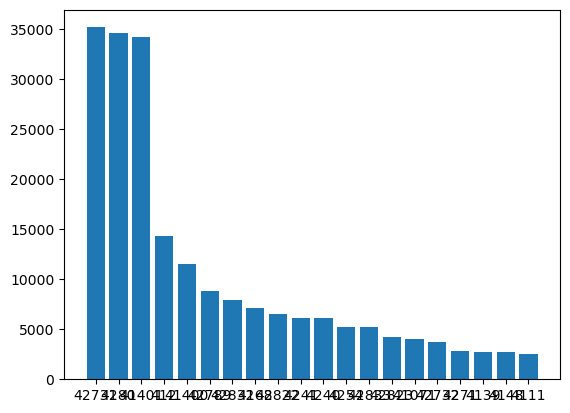

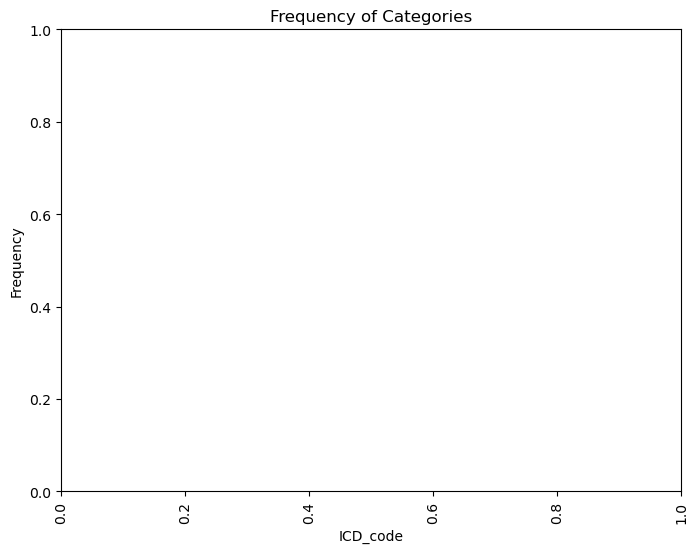

In [110]:
# Based on the below chart, there are 3 main diagnosis codes as related to the heart codes... I am happy with the 4280 code
# Create a bar chart

plt.bar(top_20_icd['icd_code'], top_20_icd['Fequency'])
plt.figure(figsize=(8, 6))
# Add labels and title
plt.xlabel('ICD_code')
plt.ylabel('Frequency')
plt.title('Frequency of Categories')
plt.xticks(rotation=90)


## Congestive Heart Failure, Unspecified Exploration 

### Deeper Dive into the 4280 Admissions

In [62]:
#34,726 admissions with the code
chv_dx_db_trial = dx_db[dx_db['icd_code'].str.contains('4280')]
print(len(chv_dx_db_trial))


34726


In [111]:
#Filter for only in cases where ICD code = 4280
chv_dx_db = dx_db[dx_db['icd_code']=='4280']
cvd_filtered_admission = admissions_db.merge(chv_dx_db, on='hadm_id', how='inner')
# cvd_filtered_admission[['subject_id_x', 'hadm_id', 'admittime', 'dischtime', 'admission_location', 'icd_code']]
print(len(cvd_filtered_admission))
# cvd_filtered_admission.info()
cvd_filtered_admission.head()

34597


,subject_id_x,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,subject_id_y,seq_num,icd_code,icd_version
0,10000980,24947999,2190-11-06 20:57:00,2190-11-08 15:58:00,NaN,EW EMER.,P434W4,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,2190-11-06 15:30:00,2190-11-06 23:16:00,0,10000980,8,4280,9
1,10000980,25242409,2191-04-03 18:48:00,2191-04-11 16:21:00,NaN,EW EMER.,P33K8A,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,2191-04-03 12:36:00,2191-04-03 20:29:00,0,10000980,8,4280,9
2,10000980,26913865,2189-06-27 07:38:00,2189-07-03 03:00:00,NaN,EW EMER.,P30KEH,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,2189-06-27 06:25:00,2189-06-27 08:42:00,0,10000980,6,4280,9
3,10000980,29654838,2188-01-03 17:41:00,2188-01-05 17:30:00,NaN,EW EMER.,P20N5X,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,2188-01-03 12:23:00,2188-01-03 18:42:00,0,10000980,10,4280,9
4,10001877,21320596,2150-11-21 23:02:00,2150-11-23 16:46:00,NaN,EU OBSERVATION,P42EMD,EMERGENCY ROOM,NaN,Other,ENGLISH,MARRIED,WHITE,2150-11-21 17:42:00,2150-11-22 00:26:00,0,10001877,2,4280,9


### Let's group patients based on those that have been readmitted, and figure out the time between readmissions

Note that the cvd_filtered_admission table only contains admissions with 4280 diagnosis

In [64]:
cvd_filtered_admission['admittime'] = pd.to_datetime(cvd_filtered_admission['admittime'])
cvd_filtered_admission['dischtime'] = pd.to_datetime(cvd_filtered_admission['dischtime'])

In [65]:
cvd_filtered_admission['admit_date'] = cvd_filtered_admission['admittime'].dt.date
cvd_filtered_admission

,subject_id_x,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,marital_status,race,edregtime,edouttime,hospital_expire_flag,subject_id_y,seq_num,icd_code,icd_version,admit_date
0,10000980,24947999,2190-11-06 20:57:00,2190-11-08 15:58:00,NaN,EW EMER.,P434W4,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,...,MARRIED,BLACK/AFRICAN AMERICAN,2190-11-06 15:30:00,2190-11-06 23:16:00,0,10000980,8,4280,9,2190-11-06
1,10000980,25242409,2191-04-03 18:48:00,2191-04-11 16:21:00,NaN,EW EMER.,P33K8A,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,...,MARRIED,BLACK/AFRICAN AMERICAN,2191-04-03 12:36:00,2191-04-03 20:29:00,0,10000980,8,4280,9,2191-04-03
2,10000980,26913865,2189-06-27 07:38:00,2189-07-03 03:00:00,NaN,EW EMER.,P30KEH,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,...,MARRIED,BLACK/AFRICAN AMERICAN,2189-06-27 06:25:00,2189-06-27 08:42:00,0,10000980,6,4280,9,2189-06-27
3,10000980,29654838,2188-01-03 17:41:00,2188-01-05 17:30:00,NaN,EW EMER.,P20N5X,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,...,MARRIED,BLACK/AFRICAN AMERICAN,2188-01-03 12:23:00,2188-01-03 18:42:00,0,10000980,10,4280,9,2188-01-03
4,10001877,21320596,2150-11-21 23:02:00,2150-11-23 16:46:00,NaN,EU OBSERVATION,P42EMD,EMERGENCY ROOM,NaN,Other,...,MARRIED,WHITE,2150-11-21 17:42:00,2150-11-22 00:26:00,0,10001877,2,4280,9,2150-11-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34592,19998330,24492004,2178-10-01 07:28:00,2178-10-08 17:40:00,NaN,EW EMER.,P039RH,EMERGENCY ROOM,HOME HEALTH CARE,Other,...,MARRIED,BLACK/AFRICAN AMERICAN,2178-10-01 05:15:00,2178-10-01 08:51:00,0,19998330,6,4280,9,2178-10-01
34593,19998330,27282608,2177-07-25 04:34:00,2177-07-26 14:07:00,NaN,EW EMER.,P25U4M,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,...,MARRIED,BLACK/AFRICAN AMERICAN,2177-07-25 02:59:00,2177-07-25 06:56:00,0,19998330,3,4280,9,2177-07-25
34594,19998497,24819607,2139-09-09 13:01:00,2139-09-10 15:30:00,NaN,URGENT,P85Q3X,PROCEDURE SITE,HOME,Other,...,WIDOWED,WHITE,NaN,NaN,0,19998497,9,4280,9,2139-09-09
34595,19998591,23299044,2185-03-10 14:19:00,2185-03-11 14:10:00,NaN,EU OBSERVATION,P2743Q,EMERGENCY ROOM,NaN,Other,...,SINGLE,WHITE,2185-03-10 10:43:00,2185-03-10 16:46:00,0,19998591,11,4280,9,2185-03-10


In [66]:
# Script to grab a patients first two admits to the hospital
def first_two_admits(series):
    sorted_series = series.sort_values()
    return sorted_series.head(2).tolist()

In [67]:
# Cell was used to compare results focused on a specific patient
filtered_df = cvd_filtered_admission[cvd_filtered_admission['subject_id_x'] == 10000980]
filtered_df

,subject_id_x,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,marital_status,race,edregtime,edouttime,hospital_expire_flag,subject_id_y,seq_num,icd_code,icd_version,admit_date
0,10000980,24947999,2190-11-06 20:57:00,2190-11-08 15:58:00,NaN,EW EMER.,P434W4,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,...,MARRIED,BLACK/AFRICAN AMERICAN,2190-11-06 15:30:00,2190-11-06 23:16:00,0,10000980,8,4280,9,2190-11-06
1,10000980,25242409,2191-04-03 18:48:00,2191-04-11 16:21:00,NaN,EW EMER.,P33K8A,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,...,MARRIED,BLACK/AFRICAN AMERICAN,2191-04-03 12:36:00,2191-04-03 20:29:00,0,10000980,8,4280,9,2191-04-03
2,10000980,26913865,2189-06-27 07:38:00,2189-07-03 03:00:00,NaN,EW EMER.,P30KEH,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,...,MARRIED,BLACK/AFRICAN AMERICAN,2189-06-27 06:25:00,2189-06-27 08:42:00,0,10000980,6,4280,9,2189-06-27
3,10000980,29654838,2188-01-03 17:41:00,2188-01-05 17:30:00,NaN,EW EMER.,P20N5X,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,...,MARRIED,BLACK/AFRICAN AMERICAN,2188-01-03 12:23:00,2188-01-03 18:42:00,0,10000980,10,4280,9,2188-01-03


In [112]:
# Convert 'admittime' to datetime
cvd_filtered_admission['admittime'] = pd.to_datetime(cvd_filtered_admission['admittime'])

# Sort the DataFrame by 'admittime' in ascending order within each 'subject_id_x' group
sorted_df = cvd_filtered_admission.sort_values(by=['subject_id_x', 'admittime'])

# Group by 'subject_id_x' and capture the first two 'admittime' values and corresponding 'hadm_id' values
first_adm_id= sorted_df.groupby('subject_id_x').head(1)
first_adm_id = first_adm_id[['subject_id_x', 'hadm_id']].rename(columns={'hadm_id': 'first_adm_id'})
first_adm_id

,subject_id_x,first_adm_id
3,10000980,29654838
4,10001877,21320596
5,10002013,21975601
9,10002155,23822395
11,10002428,23473524
...,...,...
34575,19997293,20208898
34583,19997367,23087270
34593,19998330,27282608
34594,19998497,24819607


In [69]:
result = cvd_filtered_admission.groupby('subject_id_x')['admittime'].agg(first_two_admits).reset_index()

# result_1 = cvd_filtered_admission.groupby('subject_id_x')['hadm_id'].agg(first_two_admits).reset_index()
# result_1[['First Admitted ID', 'Second Admitted ID']] = pd.DataFrame(result['hadm_id'].tolist(), index=result.index)


result[['First Admitted Time', 'Second Admitted Time']] = pd.DataFrame(result['admittime'].tolist(), index=result.index)
result.drop(columns=['admittime'], inplace=True)
result['Readmission Time'] = result['Second Admitted Time'] - result['First Admitted Time']

patient_first_adm_table = result.merge(first_adm_id, on='subject_id_x', how='left')
patient_first_adm_table.head()

# Add columns for 'First Admitted ID' and 'Second Admitted ID'

# sorted_result = result.sort_values(by='Readmission Time')
# sorted_result.head(5)

,subject_id_x,First Admitted Time,Second Admitted Time,Readmission Time,first_adm_id
0,10000980,2188-01-03 17:41:00,2189-06-27 07:38:00,540 days 13:57:00,29654838
1,10001877,2150-11-21 23:02:00,NaT,NaT,21320596
2,10002013,2159-12-14 23:55:00,2160-05-18 07:45:00,155 days 07:50:00,21975601
3,10002155,2129-08-04 12:44:00,2130-09-23 21:59:00,415 days 09:15:00,23822395
4,10002428,2156-05-11 14:49:00,NaT,NaT,23473524


The patient_first_adm_table captures the patients' first (and second) 4280 admissions and the admission ID of the first admission

In [113]:
# Define Readmission based on 90-day readmission status
patient_first_adm_table['Readmit Flag'] = 'No'
patient_first_adm_table.loc[patient_first_adm_table['Readmission Time'] < pd.Timedelta(days=90), 'Readmit Flag'] = 'Yes'

patient_first_adm_table.head(20)
# readmit_groups = result[['Readmit Flag']].value_counts()
# readmit_groups

,subject_id_x,First Admitted Time,Second Admitted Time,Readmission Time,first_adm_id,Readmit Flag
0,10000980,2188-01-03 17:41:00,2189-06-27 07:38:00,540 days 13:57:00,29654838,No
1,10001877,2150-11-21 23:02:00,NaT,NaT,21320596,No
2,10002013,2159-12-14 23:55:00,2160-05-18 07:45:00,155 days 07:50:00,21975601,No
3,10002155,2129-08-04 12:44:00,2130-09-23 21:59:00,415 days 09:15:00,23822395,No
4,10002428,2156-05-11 14:49:00,NaT,NaT,23473524,No
5,10002760,2141-04-20 07:15:00,NaT,NaT,28094813,No
6,10003400,2136-12-09 14:44:00,2137-02-24 10:00:00,76 days 19:16:00,26467376,Yes
7,10003502,2166-02-15 13:06:00,2166-02-20 15:35:00,5 days 02:29:00,20459702,Yes
8,10004235,2196-02-24 14:38:00,NaT,NaT,24181354,No
9,10004401,2141-06-06 19:20:00,2142-08-27 19:56:00,447 days 00:36:00,21085166,No


In [71]:
# Add the patient readmission column to the filtered admission table
cvd_filtered_admission_flag = cvd_filtered_admission.merge(patient_first_adm_table, on='subject_id_x', how='inner')
cvd_filtered_admission_flag.head()

# Note we probably will not need this table

,subject_id_x,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,subject_id_y,seq_num,icd_code,icd_version,admit_date,First Admitted Time,Second Admitted Time,Readmission Time,first_adm_id,Readmit Flag
0,10000980,24947999,2190-11-06 20:57:00,2190-11-08 15:58:00,NaN,EW EMER.,P434W4,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,...,10000980,8,4280,9,2190-11-06,2188-01-03 17:41:00,2189-06-27 07:38:00,540 days 13:57:00,29654838,No
1,10000980,25242409,2191-04-03 18:48:00,2191-04-11 16:21:00,NaN,EW EMER.,P33K8A,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,...,10000980,8,4280,9,2191-04-03,2188-01-03 17:41:00,2189-06-27 07:38:00,540 days 13:57:00,29654838,No
2,10000980,26913865,2189-06-27 07:38:00,2189-07-03 03:00:00,NaN,EW EMER.,P30KEH,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,...,10000980,6,4280,9,2189-06-27,2188-01-03 17:41:00,2189-06-27 07:38:00,540 days 13:57:00,29654838,No
3,10000980,29654838,2188-01-03 17:41:00,2188-01-05 17:30:00,NaN,EW EMER.,P20N5X,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,...,10000980,10,4280,9,2188-01-03,2188-01-03 17:41:00,2189-06-27 07:38:00,540 days 13:57:00,29654838,No
4,10001877,21320596,2150-11-21 23:02:00,2150-11-23 16:46:00,NaN,EU OBSERVATION,P42EMD,EMERGENCY ROOM,NaN,Other,...,10001877,2,4280,9,2150-11-21,2150-11-21 23:02:00,NaT,NaT,21320596,No


In [72]:
# Let's now filter for the first CVD admissions ! 
# Table is limited to a patient's first 4280 admission with a flag of their readmission status

first_admission_db = admissions_db.merge(patient_first_adm_table, left_on='hadm_id', right_on='first_adm_id',how='inner')
first_admission_db.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,race,edregtime,edouttime,hospital_expire_flag,subject_id_x,First Admitted Time,Second Admitted Time,Readmission Time,first_adm_id,Readmit Flag
0,10000980,29654838,2188-01-03 17:41:00,2188-01-05 17:30:00,NaN,EW EMER.,P20N5X,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,...,BLACK/AFRICAN AMERICAN,2188-01-03 12:23:00,2188-01-03 18:42:00,0,10000980,2188-01-03 17:41:00,2189-06-27 07:38:00,540 days 13:57:00,29654838,No
1,10001877,21320596,2150-11-21 23:02:00,2150-11-23 16:46:00,NaN,EU OBSERVATION,P42EMD,EMERGENCY ROOM,NaN,Other,...,WHITE,2150-11-21 17:42:00,2150-11-22 00:26:00,0,10001877,2150-11-21 23:02:00,NaT,NaT,21320596,No
2,10002013,21975601,2159-12-14 23:55:00,2159-12-17 14:04:00,NaN,EW EMER.,P96FGV,EMERGENCY ROOM,HOME,Medicare,...,WHITE,2159-12-14 21:53:00,2159-12-15 01:08:00,0,10002013,2159-12-14 23:55:00,2160-05-18 07:45:00,155 days 07:50:00,21975601,No
3,10002155,23822395,2129-08-04 12:44:00,2129-08-18 16:53:00,NaN,EW EMER.,P05HUO,PROCEDURE SITE,CHRONIC/LONG TERM ACUTE CARE,Other,...,WHITE,2129-08-04 11:00:00,2129-08-04 12:35:00,0,10002155,2129-08-04 12:44:00,2130-09-23 21:59:00,415 days 09:15:00,23822395,No
4,10002428,23473524,2156-05-11 14:49:00,2156-05-22 14:16:00,NaN,EW EMER.,P3529J,EMERGENCY ROOM,CHRONIC/LONG TERM ACUTE CARE,Medicare,...,WHITE,2156-05-11 11:29:00,2156-05-11 16:53:00,0,10002428,2156-05-11 14:49:00,NaT,NaT,23473524,No


#### Based on the results, there are a significant number of readmissions for Unspecified CHD !!

# Notes of Findings So Far

- There are 34,597 admissions with the ICD-9 4280 code of "Congestive Heart Failure, Unknown Reason"
- This comes from 14,432 patients, 8,166 of those patients were only admitted 1x for CHD
- Of those admitted multiple times, 3,068 were admitted within 90-days (2,557 60-days | 1,643 30-days)

I believe this gives me a strong enough sample size to use this as a predictive analytics model, where we want to predict whether a patient will be readmitted in 90-days for CHD again

# Let's combine other features into a master table

In [73]:
first_admission_db.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,race,edregtime,edouttime,hospital_expire_flag,subject_id_x,First Admitted Time,Second Admitted Time,Readmission Time,first_adm_id,Readmit Flag
0,10000980,29654838,2188-01-03 17:41:00,2188-01-05 17:30:00,NaN,EW EMER.,P20N5X,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,...,BLACK/AFRICAN AMERICAN,2188-01-03 12:23:00,2188-01-03 18:42:00,0,10000980,2188-01-03 17:41:00,2189-06-27 07:38:00,540 days 13:57:00,29654838,No
1,10001877,21320596,2150-11-21 23:02:00,2150-11-23 16:46:00,NaN,EU OBSERVATION,P42EMD,EMERGENCY ROOM,NaN,Other,...,WHITE,2150-11-21 17:42:00,2150-11-22 00:26:00,0,10001877,2150-11-21 23:02:00,NaT,NaT,21320596,No
2,10002013,21975601,2159-12-14 23:55:00,2159-12-17 14:04:00,NaN,EW EMER.,P96FGV,EMERGENCY ROOM,HOME,Medicare,...,WHITE,2159-12-14 21:53:00,2159-12-15 01:08:00,0,10002013,2159-12-14 23:55:00,2160-05-18 07:45:00,155 days 07:50:00,21975601,No
3,10002155,23822395,2129-08-04 12:44:00,2129-08-18 16:53:00,NaN,EW EMER.,P05HUO,PROCEDURE SITE,CHRONIC/LONG TERM ACUTE CARE,Other,...,WHITE,2129-08-04 11:00:00,2129-08-04 12:35:00,0,10002155,2129-08-04 12:44:00,2130-09-23 21:59:00,415 days 09:15:00,23822395,No
4,10002428,23473524,2156-05-11 14:49:00,2156-05-22 14:16:00,NaN,EW EMER.,P3529J,EMERGENCY ROOM,CHRONIC/LONG TERM ACUTE CARE,Medicare,...,WHITE,2156-05-11 11:29:00,2156-05-11 16:53:00,0,10002428,2156-05-11 14:49:00,NaT,NaT,23473524,No


#### Prior_admit_history includes  the number of prior hospital admissions and the time of their most recent admission

In [74]:
# Calculate the number of prior patient admissions
# and the date of their most recent admission

# Let's add the first 4280 admission time to the master admissions table, so we can filter for only admissions prior to the 4280 admission
first_admit_time = first_admission_db[['subject_id', 'First Admitted Time']]
admissions_and_first_time = admissions_db.merge(first_admit_time, on='subject_id', how='inner', suffixes=('_df1', '_df2'))

# Convert 'admission_date' and 'discharge_date' to datetime
admissions_and_first_time['admittime'] = pd.to_datetime(admissions_and_first_time['admittime'])
admissions_and_first_time['dischtime'] = pd.to_datetime(admissions_and_first_time['dischtime'])
admissions_and_first_time['First Admitted Time'] = pd.to_datetime(admissions_and_first_time['First Admitted Time'])

admissions_and_first_time.head()

# Filter admission_db for rows where 'admission_date' is less than 'First Admitted Time'
prior_admissions_only = admissions_and_first_time[admissions_and_first_time['admittime'] < admissions_and_first_time['First Admitted Time']]

print(len(admissions_and_first_time))

prior_admissions_only['length_of_stay'] = prior_admissions_only['dischtime'] - prior_admissions_only['admittime']

prior_admissions_only = prior_admissions_only[['subject_id', 'hadm_id', 'admittime', 'dischtime', 'length_of_stay']]

# prior_admissions_only.head()

# Group the DataFrame by 'subject_id'
prior_admit_history = prior_admissions_only.groupby('subject_id').agg(
    num_prior_admissions=('subject_id', 'count'),
    prior_length_of_stay=('length_of_stay', 'sum')
).reset_index()

prior_admit_history.head()

69172


C:\Users\blake\AppData\Local\Temp\ipykernel_8136\3732218785.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_admissions_only['length_of_stay'] = prior_admissions_only['dischtime'] - prior_admissions_only['admittime']


,subject_id,num_prior_admissions,prior_length_of_stay
0,10001877,1,5 days 21:42:00
1,10002013,3,8 days 23:44:00
2,10002155,1,2 days 00:59:00
3,10002428,3,20 days 21:33:00
4,10003400,2,9 days 09:37:00


#### pts_db includes gender and age

In [75]:
with gzip.open('downloads/mimic-iv-2.2/mimic-iv-2.2/hosp/patients.csv.gz') as patients:

    pts_db = pd.read_csv(patients)

pts_db.head()

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN
2,10000068,F,19,2160,2008 - 2010,NaN
3,10000084,M,72,2160,2017 - 2019,2161-02-13
4,10000102,F,27,2136,2008 - 2010,NaN


#### Let's see what pharmacy information we can get from their first 4280 visit

In [76]:
with gzip.open('downloads/mimic-iv-2.2/mimic-iv-2.2/hosp/pharmacy.csv.gz') as pharmacy:

    pharm_db = pd.read_csv(pharmacy)

pharm_db.head()

C:\Users\blake\AppData\Local\Temp\ipykernel_8136\3259881085.py:3: DtypeWarning: Columns (16,18,24,26) have mixed types. Specify dtype option on import or set low_memory=False.
  pharm_db = pd.read_csv(pharmacy)


,subject_id,hadm_id,pharmacy_id,poe_id,starttime,stoptime,medication,proc_type,status,entertime,...,basal_rate,one_hr_max,doses_per_24_hrs,duration,duration_interval,expiration_value,expiration_unit,expirationdate,dispensation,fill_quantity
0,10000032,22595853,11700683,10000032-34,2180-05-07 01:00:00,2180-05-07 22:00:00,Acetaminophen,Unit Dose,Discontinued via patient discharge,2180-05-07 00:09:24,...,NaN,NaN,NaN,NaN,Ongoing,36.0,Hours,NaN,Omnicell,NaN
1,10000032,22595853,14779570,10000032-22,2180-05-07 00:00:00,2180-05-07 22:00:00,Sodium Chloride 0.9% Flush,Unit Dose,Discontinued via patient discharge,2180-05-07 00:00:54,...,NaN,NaN,3.0,NaN,Ongoing,36.0,Hours,NaN,Floor Stock Item,NaN
2,10000032,22595853,19796602,10000032-50,2180-05-08 08:00:00,2180-05-07 22:00:00,Furosemide,Unit Dose,Discontinued via patient discharge,2180-05-07 09:32:35,...,NaN,NaN,1.0,NaN,Ongoing,36.0,Hours,NaN,Omnicell,NaN
3,10000032,22595853,20256254,10000032-32,2180-05-07 01:00:00,2180-05-07 22:00:00,Raltegravir,Unit Dose,Discontinued via patient discharge,2180-05-07 00:09:24,...,NaN,NaN,2.0,NaN,Ongoing,36.0,Hours,NaN,Omnicell,NaN
4,10000032,22595853,28781051,10000032-27,2180-05-07 00:00:00,2180-05-07 22:00:00,Heparin,Unit Dose,Discontinued via patient discharge,2180-05-07 00:00:54,...,NaN,NaN,3.0,NaN,Ongoing,36.0,Hours,NaN,Omnicell,NaN


In [77]:
pharm_first_4280 = pharm_db.merge(patient_first_adm_table, left_on = 'hadm_id', right_on = 'first_adm_id', how='inner')
pharm_first_4280.sort_values('hadm_id').head()

,subject_id,hadm_id,pharmacy_id,poe_id,starttime,stoptime,medication,proc_type,status,entertime,...,expiration_unit,expirationdate,dispensation,fill_quantity,subject_id_x,First Admitted Time,Second Admitted Time,Readmission Time,first_adm_id,Readmit Flag
211092,12640657,20000235,63017660,12640657-33,2139-11-13 14:00:00,2139-11-13 15:00:00,Midodrine,Unit Dose,Inactive (Due to a change order),2139-11-13 10:50:46,...,Hours,NaN,Omnicell,NaN,12640657,2139-11-13 03:55:00,NaT,NaT,20000235,No
211091,12640657,20000235,59993333,12640657-56,2139-11-13 10:00:00,2139-12-03 17:00:00,Allopurinol,Unit Dose,Discontinued via patient discharge,2139-11-13 16:01:16,...,Hours,NaN,Omnicell,NaN,12640657,2139-11-13 03:55:00,NaT,NaT,20000235,No
211090,12640657,20000235,58258265,12640657-69,2139-11-15 20:00:00,2139-11-20 18:00:00,Lactulose,Unit Dose,Inactive (Due to a change order),2139-11-15 15:21:18,...,Hours,NaN,Omnicell,NaN,12640657,2139-11-13 03:55:00,NaT,NaT,20000235,No
211101,12640657,20000235,81453329,12640657-146,2139-11-28 20:00:00,2139-11-29 19:00:00,Carbamide Peroxide 6.5%,Unit Dose,Expired,2139-11-28 16:35:54,...,Hours,NaN,Bulk Item,NaN,12640657,2139-11-13 03:55:00,NaT,NaT,20000235,No
211089,12640657,20000235,52637363,12640657-54,2139-11-13 13:00:00,2139-11-13 16:00:00,Allopurinol,Unit Dose,Inactive (Due to a change order),2139-11-13 12:42:37,...,Hours,NaN,Omnicell,NaN,12640657,2139-11-13 03:55:00,NaT,NaT,20000235,No


In [78]:
## Based on the pharm_first_4280 it looks like patients receive a lot of medications for their visit
## I do not know how to make sense of the mediciations (i.e. which ones are the most severe)
## Thus I am unable to really prioritize the medications to drive insights
## But what I can do is sum the total number of medications and how that provides some insights

pharm_num_medications = pharm_first_4280.groupby('subject_id').agg(
                                                total_medications=('medication', 'count')
                                                ).reset_index()
pharm_num_medications.head()

,subject_id,total_medications
0,10000980,45
1,10001877,19
2,10002013,23
3,10002155,75
4,10002428,71


#### We will do a similar thing with the HCPCS Events table

In [79]:
with gzip.open('downloads/mimic-iv-2.2/mimic-iv-2.2/hosp/hcpcsevents.csv.gz') as hcpcsevent:

    hcpcs_events_db = pd.read_csv(hcpcsevent)

In [122]:
hcpcs_first_4280 = hcpcs_events_db.merge(patient_first_adm_table, left_on = 'hadm_id', right_on = 'first_adm_id', how='inner')
hcpcs_first_4280.sort_values('hadm_id').head()
hcpcs_events_in_first_adm = hcpcs_first_4280.groupby('hadm_id').agg(
                                                total_hcpcs=('hadm_id', 'count')
                                                ).reset_index()
hcpcs_events_in_first_adm.head(50)

,hadm_id,total_hcpcs
0,20002712,1
1,20014990,1
2,20026711,1
3,20041128,2
4,20057692,1
5,20065216,1
6,20085518,1
7,20094341,1
8,20116102,1
9,20118373,5


****Lets add a BMI table to the information****

(array([  8.,  26., 111., 263., 723., 499., 370., 272., 188., 141.]),
 array([11.6 , 14.44, 17.28, 20.12, 22.96, 25.8 , 28.64, 31.48, 34.32,
        37.16, 40.  ]),
 <BarContainer object of 10 artists>)

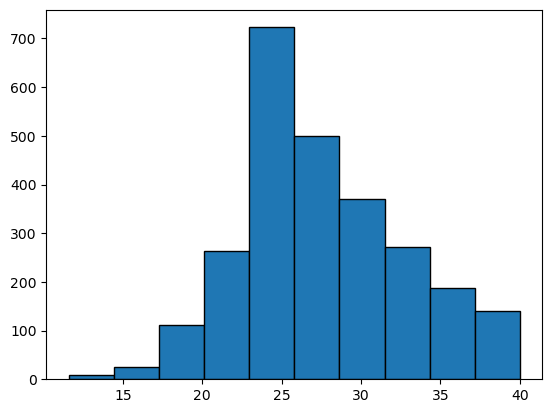

In [161]:
admit_bmi = first_admission_db[['subject_id', 'admittime']].merge(omr_db, on = 'subject_id', how='inner')
admit_bmi['admittime'] = pd.to_datetime(admit_bmi['admittime'])
admit_bmi['chartdate'] = pd.to_datetime(admit_bmi['chartdate'])

# Calculate the absolute difference in days between admittime and chartdate
admit_bmi['time_diff'] = (admit_bmi['admittime'] - admit_bmi['chartdate']).abs()

# Convert time difference to days
admit_bmi['time_diff'] = admit_bmi['time_diff'].dt.days

# Filter rows where time difference is less than or equal to 20 days
admit_bmi = admit_bmi[admit_bmi['time_diff'] <= 5]

# Drop the time_diff column if not needed
admit_bmi = admit_bmi.drop(columns=['time_diff'])

# Filter the DataFrame where result_name is 'BMI (kg/m2)'
admit_bmi = admit_bmi[admit_bmi['result_name'] == 'BMI (kg/m2)']
# admit_bmi.info()

# Convert non-numeric values to NaN and then drop these rows
admit_bmi['result_value'] = pd.to_numeric(admit_bmi['result_value'], errors='coerce')
admit_bmi = admit_bmi.dropna(subset=['result_value'])

# # # Group by subject_id and calculate the average BMI
avg_bmi_df = admit_bmi.groupby('subject_id')['result_value'].mean().reset_index()

# avg_bmi_df.sort_values(by=['result_value'], ascending=False).head()
# # The avg_bmi_df now contains subject_id and the average BMI

avg_bmi_df.loc[(avg_bmi_df['result_value'] < 10) | (avg_bmi_df['result_value'] > 40), 'result_value'] = 24
avg_bmi_df.rename(columns={'result_value' :'bmi'}, inplace=True)

plt.hist(avg_bmi_df['bmi'], edgecolor='black')

# sort_values(by=['subject_id_x', 'admittime'])



In [390]:
avg_bmi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2601 entries, 0 to 2600
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   subject_id  2601 non-null   int64  
 1   bmi         2601 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 40.8 KB


### Let's try to add blood pressure information

In [326]:
admit_bp = first_admission_db[['subject_id', 'admittime']].merge(omr_db, on = 'subject_id', how='inner')
admit_bp['admittime'] = pd.to_datetime(admit_bp['admittime'])
admit_bp['chartdate'] = pd.to_datetime(admit_bp['chartdate'])

# Calculate the absolute difference in days between admittime and chartdate
admit_bp['time_diff'] = (admit_bp['admittime'] - admit_bp['chartdate']).abs()

# Convert time difference to days
admit_bp['time_diff'] = admit_bp['time_diff'].dt.days

# Filter rows where time difference is less than or equal to 20 days
admit_bp = admit_bp[admit_bp['time_diff'] <= 5]

# Drop the time_diff column if not needed
admit_bp = admit_bp.drop(columns=['time_diff'])

# Filter the DataFrame where result_name is 'BMI (kg/m2)'
admit_bp = admit_bp[admit_bp['result_name'] == 'Blood Pressure']
admit_bp [['systolic_bp', 'diastolic_bp']] = admit_bp['result_value'].str.split('/', expand=True)
admit_bp['systolic_bp'] = pd.to_numeric(admit_bp['systolic_bp'])
admit_bp['diastolic_bp'] = pd.to_numeric(admit_bp['diastolic_bp'])

# # # Group by subject_id and calculate the average BMI
admit_bp_df = admit_bp.groupby('subject_id')['systolic_bp', 'diastolic_bp'].mean().reset_index() 

admit_bp_df['bp_ratio'] = admit_bp_df['systolic_bp'] / admit_bp_df['diastolic_bp']
admit_bp_df['systolic_bp'] = pd.to_numeric(admit_bp_df['systolic_bp'])

admit_bp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subject_id    1490 non-null   int64  
 1   systolic_bp   1490 non-null   float64
 2   diastolic_bp  1490 non-null   float64
 3   bp_ratio      1490 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 46.7 KB


C:\Users\blake\AppData\Local\Temp\ipykernel_8136\1425867418.py:24: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  admit_bp_df = admit_bp.groupby('subject_id')['systolic_bp', 'diastolic_bp'].mean().reset_index()


# Combining my features into a single table
- first_admission_db: Captures the admissions table of the patient's first 4280 admission
- prior_admit_history: Number of prior admissions and total time in hospital prior
- pts_db: Contains sex & age
- pharm_num_medications: Count of the total number of medications in the first 4280 admission
- hcpcs_events_in_first_adm: Count of the total number of hcpcs in the first 4280 admission

In [327]:
from datetime import timedelta

features_table = first_admission_db.merge(prior_admit_history, on='subject_id', how='left')
features_table = features_table.merge(prior_admit_history, on='subject_id', how='left')
features_table = features_table.merge(pts_db, on='subject_id', how='left')
features_table = features_table.merge(pharm_num_medications, on='subject_id', how='left')
features_table = features_table.merge(hcpcs_events_in_first_adm, on='hadm_id', how='left')
features_table = features_table.merge(avg_bmi_df, on='subject_id', how='left')
features_table = features_table.merge(admit_bp_df, on='subject_id', how='left')
features_table['systolic_bp'].fillna(127, inplace=True)
features_table['diastolic_bp'].fillna(70, inplace=True)
features_table['bp_ratio'].fillna(1.8, inplace=True)
features_table['bmi'].fillna(20, inplace=True)
features_table['num_prior_admissions_x'].fillna(0, inplace=True)
features_table['prior_length_of_stay_x'].fillna(timedelta(0), inplace=True)
features_table['total_medications'].fillna(0, inplace=True)
features_table['total_hcpcs'].fillna(0, inplace=True)


features_table['admittime'] = pd.to_datetime(features_table['admittime'])
features_table['dischtime'] = pd.to_datetime(features_table['dischtime'])
features_table['admit_LOS'] = features_table['dischtime'] - features_table['admittime']
features_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14432 entries, 0 to 14431
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   subject_id              14432 non-null  int64          
 1   hadm_id                 14432 non-null  int64          
 2   admittime               14432 non-null  datetime64[ns] 
 3   dischtime               14432 non-null  datetime64[ns] 
 4   deathtime               798 non-null    object         
 5   admission_type          14432 non-null  object         
 6   admit_provider_id       14432 non-null  object         
 7   admission_location      14432 non-null  object         
 8   discharge_location      13315 non-null  object         
 9   insurance               14432 non-null  object         
 10  language                14432 non-null  object         
 11  marital_status          13960 non-null  object         
 12  race                    14432 no

In [328]:
features_to_include = [
    'admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'marital_status', 
    'race', 'Readmit Flag', 'num_prior_admissions_x', 'prior_length_of_stay_x', 'gender', 'anchor_age', 'total_medications', 
    'total_hcpcs', 'admit_LOS', 'bmi', 'systolic_bp', 'diastolic_bp', 'bp_ratio'
]

In [329]:
features_master_table = features_table[features_to_include]

In [330]:
features_master_table.head()

,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,Readmit Flag,num_prior_admissions_x,prior_length_of_stay_x,gender,anchor_age,total_medications,total_hcpcs,admit_LOS,bmi,systolic_bp,diastolic_bp,bp_ratio
0,EW EMER.,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,No,0.0,0 days 00:00:00,F,73,45.0,0.0,1 days 23:49:00,20.0,127.0,70.0,1.800000
1,EU OBSERVATION,EMERGENCY ROOM,NaN,Other,ENGLISH,MARRIED,WHITE,No,1.0,5 days 21:42:00,M,89,19.0,1.0,1 days 17:44:00,20.0,127.0,70.0,1.800000
2,EW EMER.,EMERGENCY ROOM,HOME,Medicare,ENGLISH,SINGLE,WHITE,No,3.0,8 days 23:44:00,F,53,23.0,0.0,2 days 14:09:00,37.1,123.0,69.0,1.782609
3,EW EMER.,PROCEDURE SITE,CHRONIC/LONG TERM ACUTE CARE,Other,ENGLISH,MARRIED,WHITE,No,1.0,2 days 00:59:00,F,80,75.0,0.0,14 days 04:09:00,20.0,127.0,70.0,1.800000
4,EW EMER.,EMERGENCY ROOM,CHRONIC/LONG TERM ACUTE CARE,Medicare,ENGLISH,WIDOWED,WHITE,No,3.0,20 days 21:33:00,F,80,71.0,0.0,10 days 23:27:00,20.0,127.0,70.0,1.800000


In [177]:
features_master_table

,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,Readmit Flag,num_prior_admissions_x,prior_length_of_stay_x,gender,anchor_age,total_medications,total_hcpcs,admit_LOS,bmi
0,EW EMER.,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,No,0.0,0 days 00:00:00,F,73,45.0,0.0,1 days 23:49:00,20.000000
1,EU OBSERVATION,EMERGENCY ROOM,NaN,Other,ENGLISH,MARRIED,WHITE,No,1.0,5 days 21:42:00,M,89,19.0,1.0,1 days 17:44:00,20.000000
2,EW EMER.,EMERGENCY ROOM,HOME,Medicare,ENGLISH,SINGLE,WHITE,No,3.0,8 days 23:44:00,F,53,23.0,0.0,2 days 14:09:00,37.100000
3,EW EMER.,PROCEDURE SITE,CHRONIC/LONG TERM ACUTE CARE,Other,ENGLISH,MARRIED,WHITE,No,1.0,2 days 00:59:00,F,80,75.0,0.0,14 days 04:09:00,20.000000
4,EW EMER.,EMERGENCY ROOM,CHRONIC/LONG TERM ACUTE CARE,Medicare,ENGLISH,WIDOWED,WHITE,No,3.0,20 days 21:33:00,F,80,71.0,0.0,10 days 23:27:00,20.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14427,URGENT,TRANSFER FROM HOSPITAL,SKILLED NURSING FACILITY,Medicare,ENGLISH,SINGLE,WHITE,Yes,0.0,0 days 00:00:00,M,76,141.0,0.0,18 days 01:27:00,20.000000
14428,DIRECT EMER.,PHYSICIAN REFERRAL,HOME,Medicare,ENGLISH,MARRIED,WHITE,Yes,0.0,0 days 00:00:00,F,63,21.0,0.0,1 days 01:37:00,27.533333
14429,EW EMER.,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,No,0.0,0 days 00:00:00,F,71,32.0,0.0,1 days 09:33:00,20.000000
14430,URGENT,PROCEDURE SITE,HOME,Other,ENGLISH,WIDOWED,WHITE,No,1.0,3 days 20:41:00,F,82,18.0,0.0,1 days 02:29:00,20.000000


In [331]:
mapping = {'Yes': 1, 'No':0 }
features_master_table['Readmit Flag'] = features_master_table['Readmit Flag'].map(mapping)
features_master_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14432 entries, 0 to 14431
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   admission_type          14432 non-null  object         
 1   admission_location      14432 non-null  object         
 2   discharge_location      13315 non-null  object         
 3   insurance               14432 non-null  object         
 4   language                14432 non-null  object         
 5   marital_status          13960 non-null  object         
 6   race                    14432 non-null  object         
 7   Readmit Flag            14432 non-null  int64          
 8   num_prior_admissions_x  14432 non-null  float64        
 9   prior_length_of_stay_x  14432 non-null  timedelta64[ns]
 10  gender                  14432 non-null  object         
 11  anchor_age              14432 non-null  int64          
 12  total_medications       14432 no

C:\Users\blake\AppData\Local\Temp\ipykernel_8136\3565673867.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_master_table['Readmit Flag'] = features_master_table['Readmit Flag'].map(mapping)


In [179]:
features_master_table.head()

,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,Readmit Flag,num_prior_admissions_x,prior_length_of_stay_x,gender,anchor_age,total_medications,total_hcpcs,admit_LOS,bmi
0,EW EMER.,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,0,0.0,0 days 00:00:00,F,73,45.0,0.0,1 days 23:49:00,20.0
1,EU OBSERVATION,EMERGENCY ROOM,NaN,Other,ENGLISH,MARRIED,WHITE,0,1.0,5 days 21:42:00,M,89,19.0,1.0,1 days 17:44:00,20.0
2,EW EMER.,EMERGENCY ROOM,HOME,Medicare,ENGLISH,SINGLE,WHITE,0,3.0,8 days 23:44:00,F,53,23.0,0.0,2 days 14:09:00,37.1
3,EW EMER.,PROCEDURE SITE,CHRONIC/LONG TERM ACUTE CARE,Other,ENGLISH,MARRIED,WHITE,0,1.0,2 days 00:59:00,F,80,75.0,0.0,14 days 04:09:00,20.0
4,EW EMER.,EMERGENCY ROOM,CHRONIC/LONG TERM ACUTE CARE,Medicare,ENGLISH,WIDOWED,WHITE,0,3.0,20 days 21:33:00,F,80,71.0,0.0,10 days 23:27:00,20.0


In [217]:
df = features_master_table
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14432 entries, 0 to 14431
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   admission_type          14432 non-null  object         
 1   admission_location      14432 non-null  object         
 2   discharge_location      13315 non-null  object         
 3   insurance               14432 non-null  object         
 4   language                14432 non-null  object         
 5   marital_status          13960 non-null  object         
 6   race                    14432 non-null  object         
 7   Readmit Flag            14432 non-null  int64          
 8   num_prior_admissions_x  14432 non-null  float64        
 9   prior_length_of_stay_x  14432 non-null  timedelta64[ns]
 10  gender                  14432 non-null  object         
 11  anchor_age              14432 non-null  int64          
 12  total_medications       14432 no

In [332]:
df['num_prior_admissions_x'].fillna(0, inplace=True)
df['anchor_age'].fillna(0, inplace=True)
df['total_medications'].fillna(0, inplace=True)
df['total_hcpcs'].fillna(0, inplace=True)


df['num_prior_admissions_x'] = df['num_prior_admissions_x'].astype('int64')
df['anchor_age'] = df['anchor_age'].astype('int64')
df['total_medications'] = df['total_medications'].astype('int64')
df['total_hcpcs'] = df['total_hcpcs'].astype('int64')
df['bmi'] = df['bmi'].astype('int64')
df['systolic_bp'] = df['bmi'].astype('int64')
df['diastolic_bp'] = df['bmi'].astype('int64')
df['bp_ratio'] = df['bmi'].astype('int64')

In [219]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14432 entries, 0 to 14431
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   admission_type          14432 non-null  object         
 1   admission_location      14432 non-null  object         
 2   discharge_location      13315 non-null  object         
 3   insurance               14432 non-null  object         
 4   language                14432 non-null  object         
 5   marital_status          13960 non-null  object         
 6   race                    14432 non-null  object         
 7   Readmit Flag            14432 non-null  int64          
 8   num_prior_admissions_x  14432 non-null  int64          
 9   prior_length_of_stay_x  14432 non-null  timedelta64[ns]
 10  gender                  14432 non-null  object         
 11  anchor_age              14432 non-null  int64          
 12  total_medications       14432 no

In [343]:
import seaborn as sns

In [344]:
object_col = df.select_dtypes(include=['object']).columns.tolist()
print(object_col)

['admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'marital_status', 'race', 'gender', 'race_modified']


In [345]:
int_col = df.select_dtypes(include=['int']).columns.tolist()
print(int_col)

['Readmit Flag', 'num_prior_admissions_x', 'anchor_age', 'total_medications', 'total_hcpcs', 'bmi', 'systolic_bp', 'diastolic_bp', 'bp_ratio']


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'EMERGENCY ROOM'),
  Text(1, 0, 'PROCEDURE SITE'),
  Text(2, 0, 'PHYSICIAN REFERRAL'),
  Text(3, 0, 'TRANSFER FROM HOSPITAL'),
  Text(4, 0, 'CLINIC REFERRAL'),
  Text(5, 0, 'TRANSFER FROM SKILLED NURSING FACILITY'),
  Text(6, 0, 'PACU'),
  Text(7, 0, 'INTERNAL TRANSFER TO OR FROM PSYCH')])

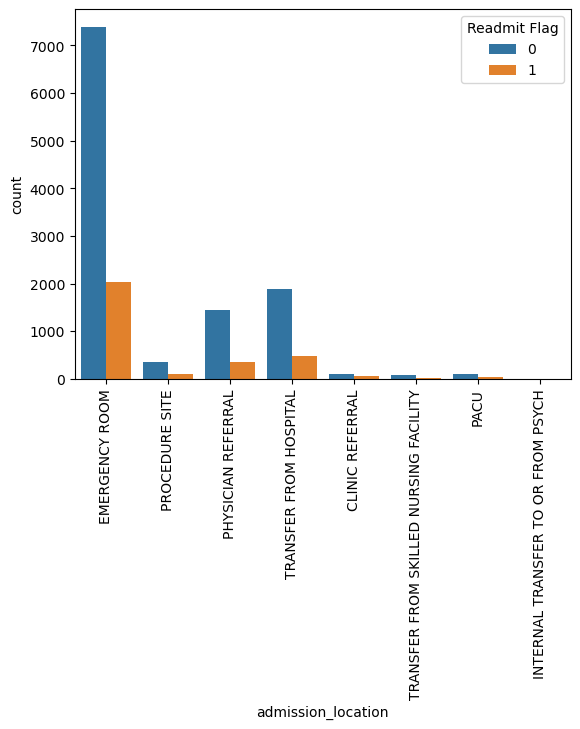

In [346]:
sns.countplot(x = 'admission_location', data=df, hue='Readmit Flag')
plt.xticks(rotation=90)

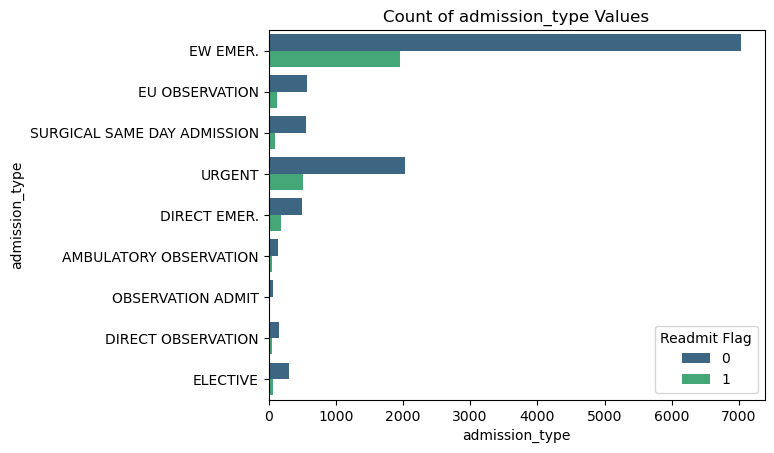

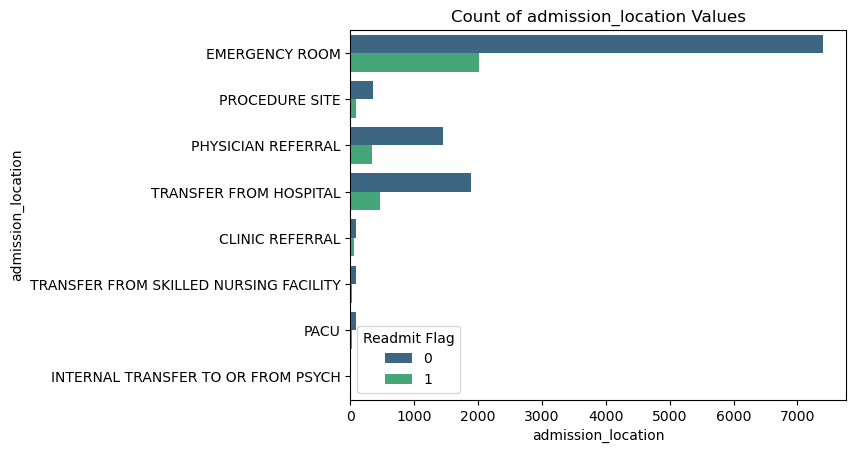

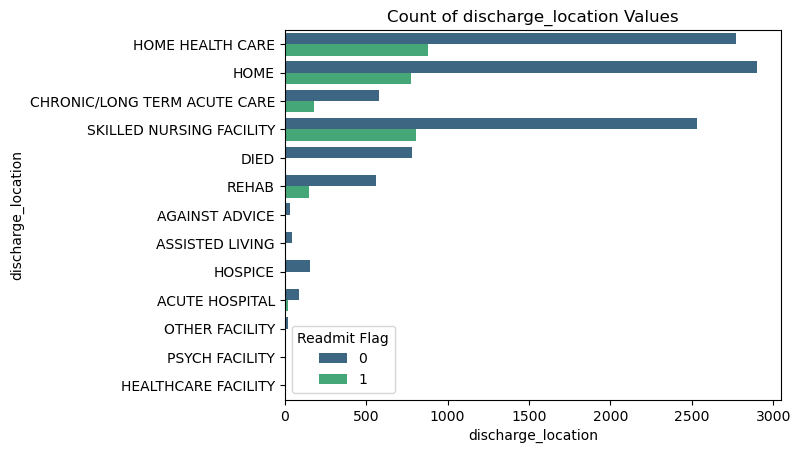

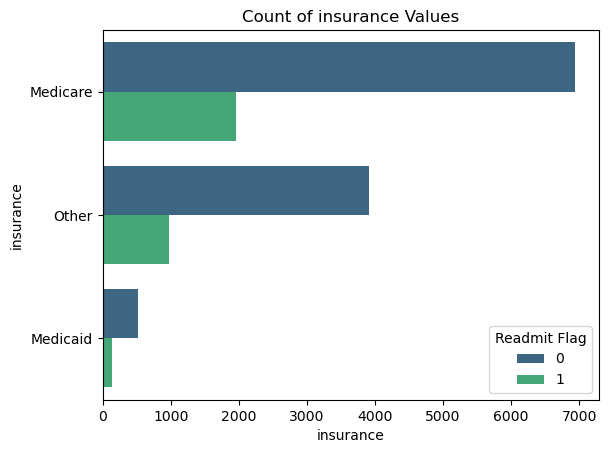

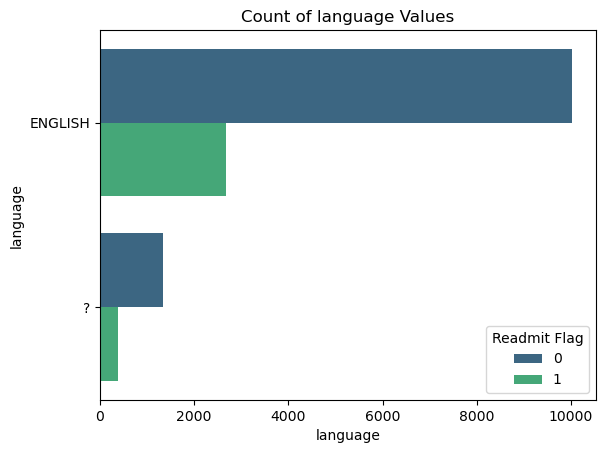

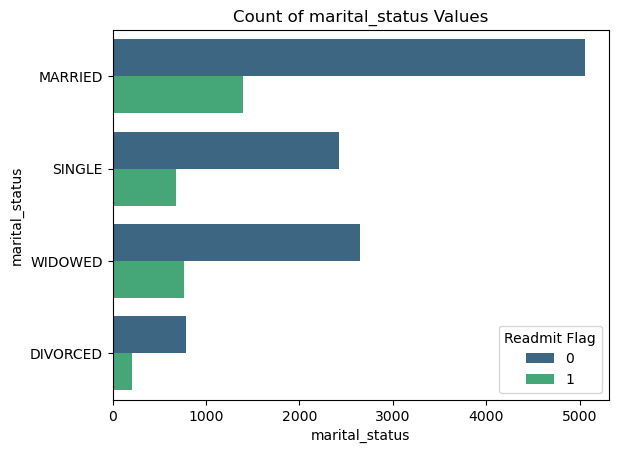

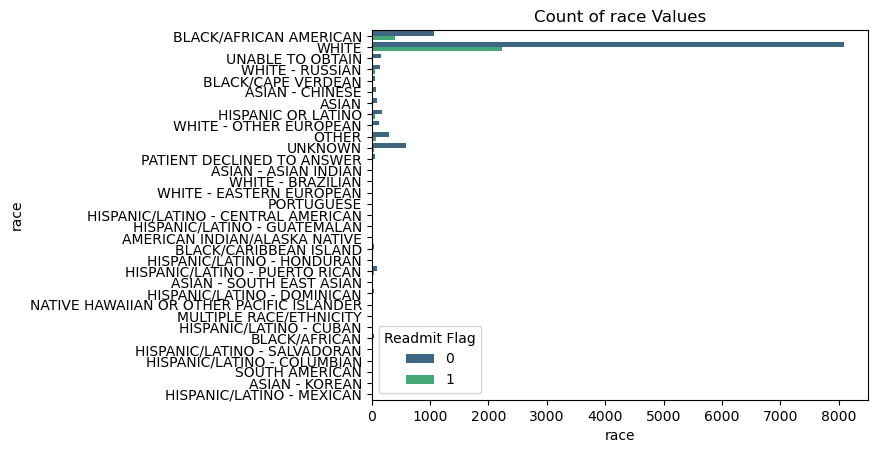

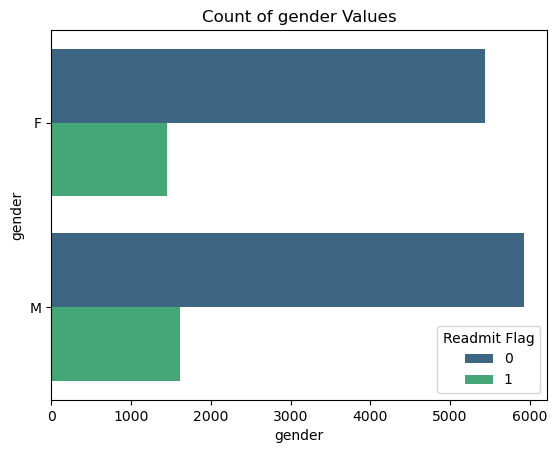

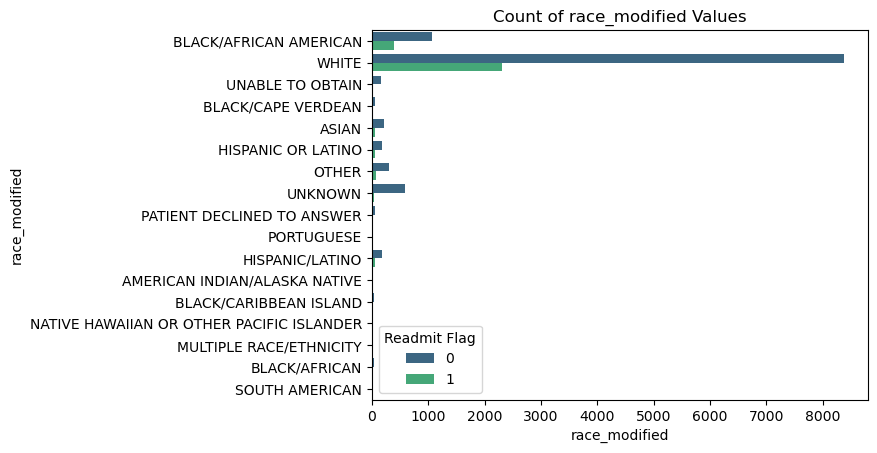

In [185]:


for col in object_col:
    fig = sns.countplot(y=col, data=df, palette = 'viridis', hue='Readmit Flag')
    fig.set_yticklabels(fig.get_yticklabels(), rotation=0)
    plt.xlabel(col)
    plt.title(f'Count of {col} Values')
    plt.show()

In [391]:
print(df['Readmit Flag'].sum())

3068


In [394]:
print(features_table['subject_id'].nunique())

14432


### Notes based on figures
- admission_type: Could potentially group Ambulatory Observation, Observation Admit, and Direct Observation, but for now lets stick with it 
- admission_location: Looks good 

### Immediate Actions
- Remove rows where discharge location = DIED, HOSPICE
- Remove language column since we only have English. Other languages have a ? 
- Need to rework the Race column. Can use this code df['NewColumn'] = df['OriginalColumn'].str.split(' - ', expand=True)[0] 

In [347]:
df['race_modified'] = df['race'].str.split(' - ', expand=True)[0]
df.head()

,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,Readmit Flag,num_prior_admissions_x,prior_length_of_stay_x,gender,anchor_age,total_medications,total_hcpcs,admit_LOS,bmi,race_modified,systolic_bp,diastolic_bp,bp_ratio
0,EW EMER.,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,0,0,0 days 00:00:00,F,73,45,0,1 days 23:49:00,20,BLACK/AFRICAN AMERICAN,20,20,20
1,EU OBSERVATION,EMERGENCY ROOM,NaN,Other,ENGLISH,MARRIED,WHITE,0,1,5 days 21:42:00,M,89,19,1,1 days 17:44:00,20,WHITE,20,20,20
2,EW EMER.,EMERGENCY ROOM,HOME,Medicare,ENGLISH,SINGLE,WHITE,0,3,8 days 23:44:00,F,53,23,0,2 days 14:09:00,37,WHITE,37,37,37
3,EW EMER.,PROCEDURE SITE,CHRONIC/LONG TERM ACUTE CARE,Other,ENGLISH,MARRIED,WHITE,0,1,2 days 00:59:00,F,80,75,0,14 days 04:09:00,20,WHITE,20,20,20
4,EW EMER.,EMERGENCY ROOM,CHRONIC/LONG TERM ACUTE CARE,Medicare,ENGLISH,WIDOWED,WHITE,0,3,20 days 21:33:00,F,80,71,0,10 days 23:27:00,20,WHITE,20,20,20


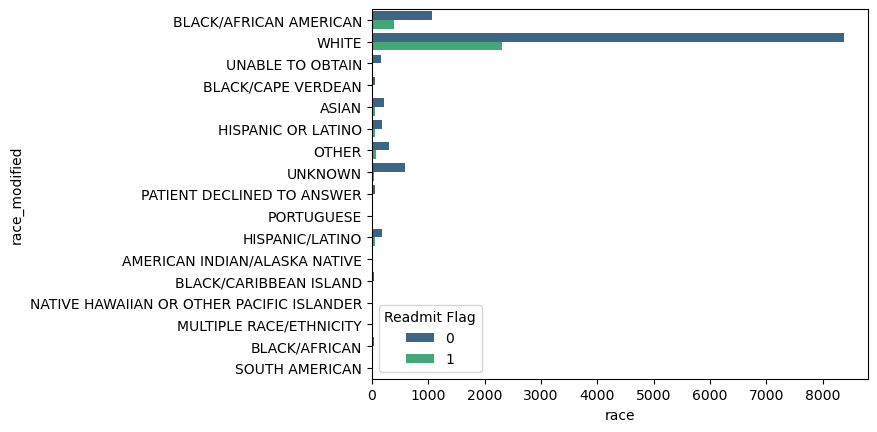

In [348]:
df_1 = df.drop(['race', 'language'], axis=1)

fig = sns.countplot(y='race_modified', data=df_1, palette = 'viridis', hue='Readmit Flag')
fig.set_yticklabels(fig.get_yticklabels(), rotation=0)
plt.xlabel('race')
plt.show()

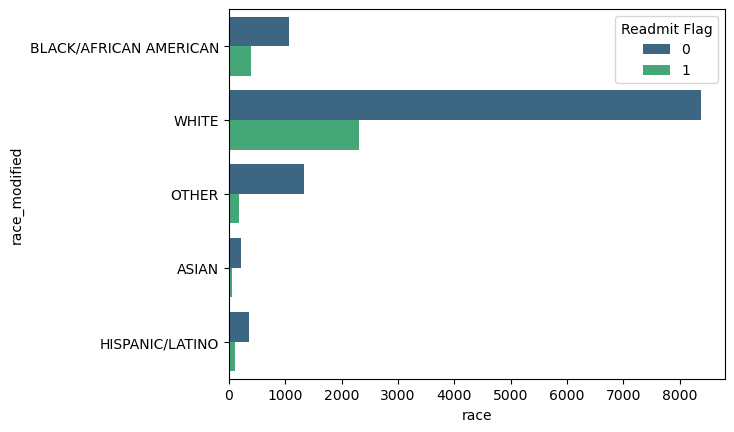

In [349]:
small_race_samples = ['PATIENT DECLINED TO ANSWER', 'PORTUGUESE', 'AMERICAN INDIAN/ALASKA NATIVE', 'BLACK/CARIBBEAN ISLAND', 
                     'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'MULTIPLE RACE/ETHNICITY', 'BLACK/AFRICAN','SOUTH AMERICAN',
                     'BLACK/CAPE VERDEAN', 'UNABLE TO OBTAIN', 'UNKNOWN']

race_mapping = {category: 'OTHER' for category in small_race_samples}
df_1['race_modified'] = df['race_modified'].replace(race_mapping)

hispanic_mapping = {'HISPANIC OR LATINO': 'HISPANIC/LATINO'}
df_1['race_modified'] = df_1['race_modified'].replace(hispanic_mapping)

fig = sns.countplot(y='race_modified', data=df_1, palette = 'viridis', hue='Readmit Flag')
fig.set_yticklabels(fig.get_yticklabels(), rotation=0)
plt.xlabel('race')
plt.show()


In [350]:
# Let's remove some discharge_location values and prior length of stay values
df_1 = df_1[df_1['discharge_location'] != 'DIED']
df_1 = df_1[df_1['discharge_location'] != 'HOSPICE']
df_1['prior_length_of_stay_x'].fillna(pd.Timedelta(days=0), inplace=True)

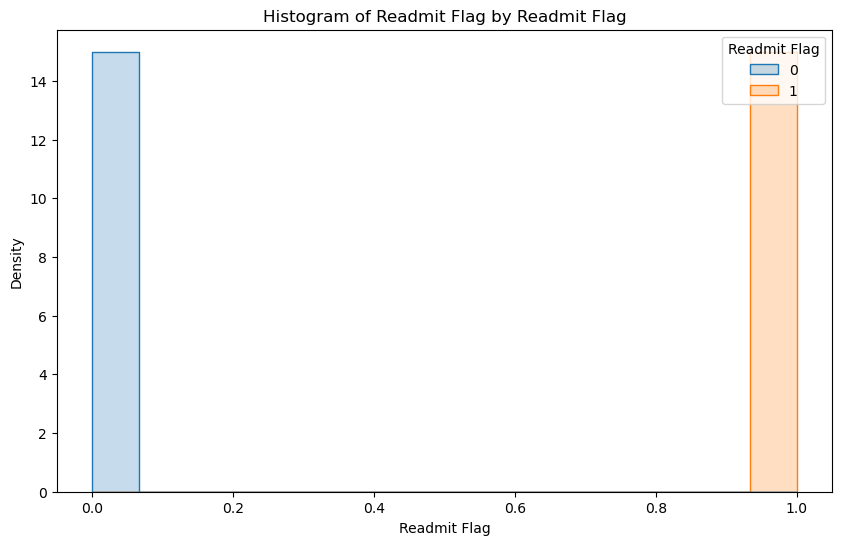

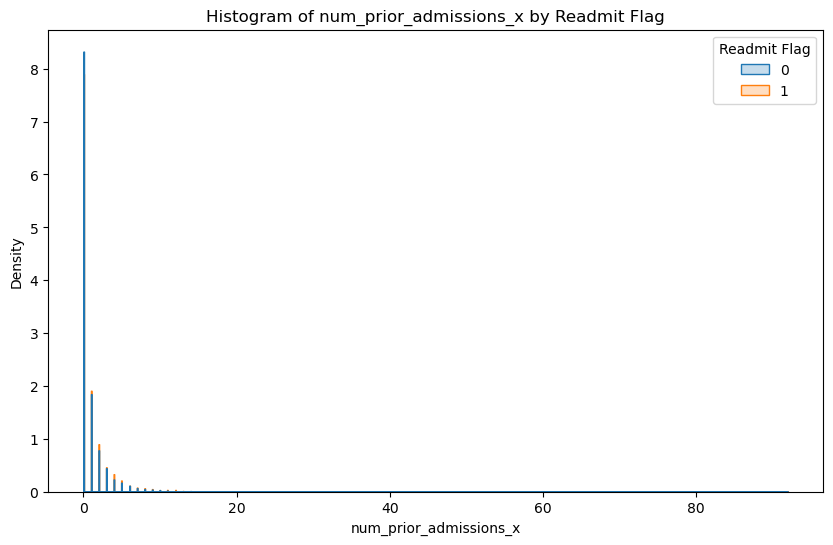

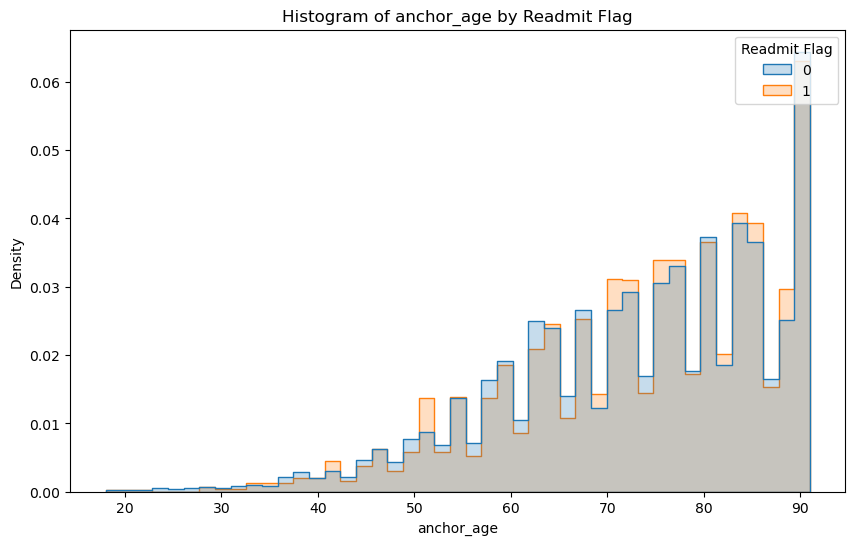

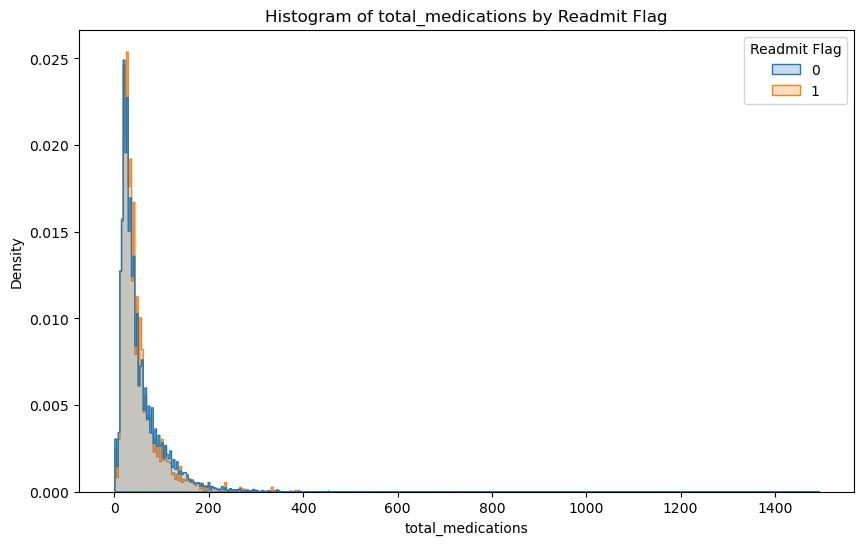

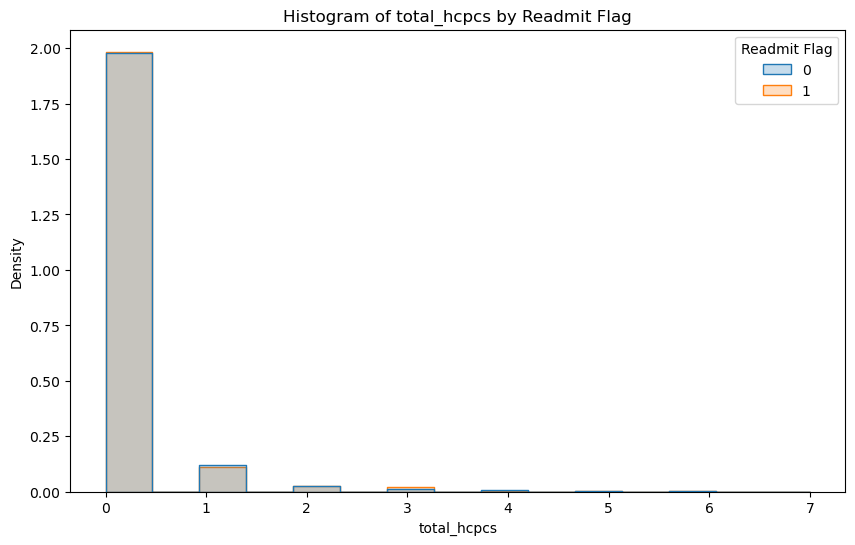

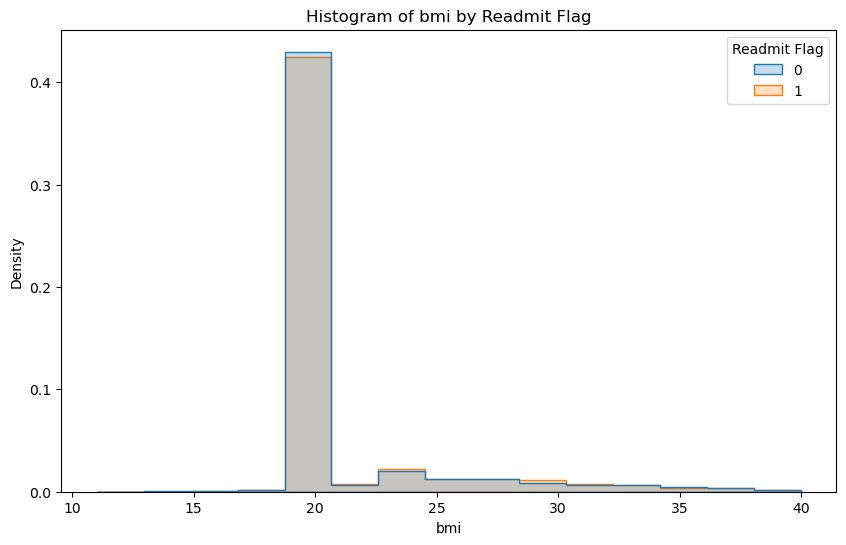

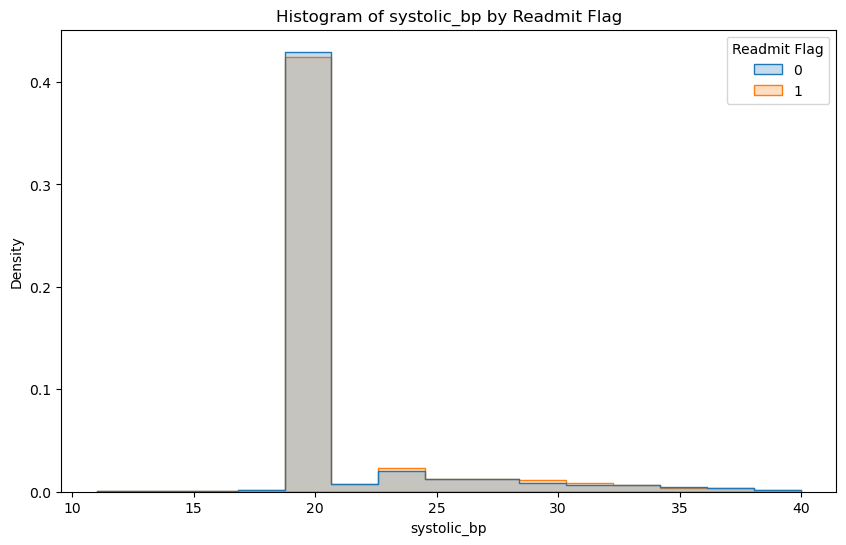

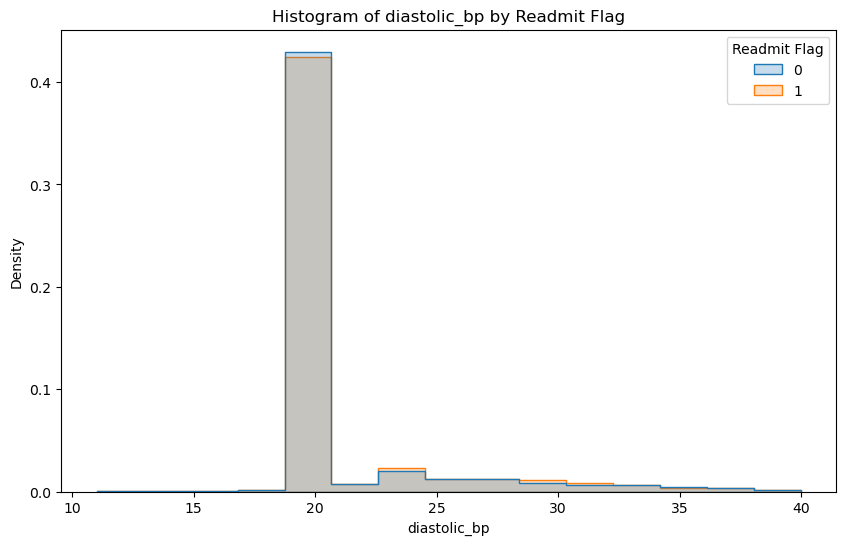

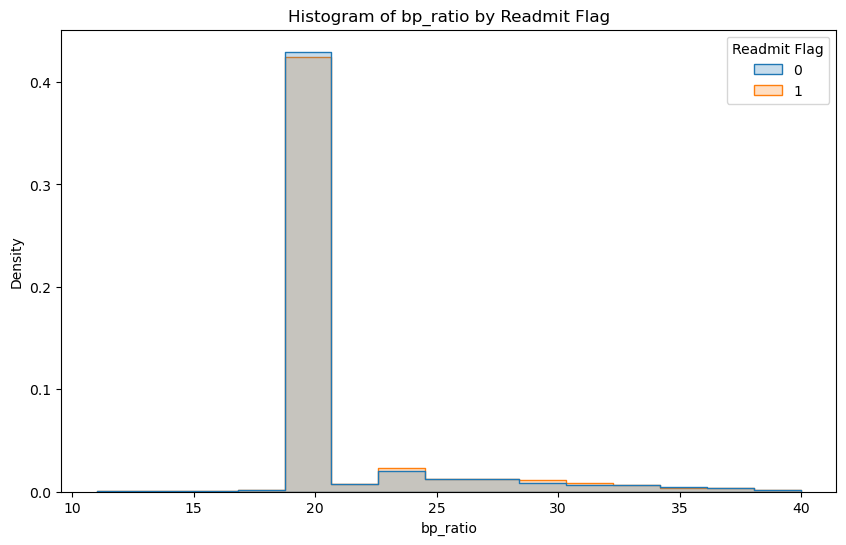

In [399]:
# Select only numeric columns
numeric_cols = df_1.select_dtypes(include=['int64']).columns

# Loop through numeric columns and create histograms
for col in numeric_cols:
    plt.figure(figsize=(10, 6))  # Adjust the figure size as necessary
    sns.histplot(data=df, x=col, hue='Readmit Flag', element='step', stat='density', common_norm=False)
    plt.title(f'Histogram of {col} by Readmit Flag')
    plt.ylabel('Density')
    plt.show()

In [351]:
df_1.dropna(inplace=True)

In [365]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12038 entries, 0 to 14430
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   admission_type          12038 non-null  object         
 1   admission_location      12038 non-null  object         
 2   discharge_location      12038 non-null  object         
 3   insurance               12038 non-null  object         
 4   marital_status          12038 non-null  object         
 5   Readmit Flag            12038 non-null  int64          
 6   num_prior_admissions_x  12038 non-null  int64          
 7   prior_length_of_stay_x  12038 non-null  timedelta64[ns]
 8   gender                  12038 non-null  object         
 9   anchor_age              12038 non-null  int64          
 10  total_medications       12038 non-null  int64          
 11  total_hcpcs             12038 non-null  int64          
 12  admit_LOS               12038 no

In [400]:
df_1.describe()

,Readmit Flag,num_prior_admissions_x,prior_length_of_stay_x,anchor_age,total_medications,total_hcpcs,admit_LOS,bmi,systolic_bp,diastolic_bp,bp_ratio
count,12038.000000,12038.000000,12038,12038.000000,12038.000000,12038.000000,12038,12038.000000,12038.000000,12038.000000,12038.000000
mean,0.233261,0.877139,3 days 20:29:55.240073101,72.845157,53.104253,0.003821,7 days 00:41:53.256354876,21.284765,21.284765,21.284765,21.284765
std,0.422925,2.338641,12 days 12:06:34.323953162,13.507574,47.265689,0.096385,7 days 15:56:03.267196721,3.512446,3.512446,3.512446,3.512446
min,0.000000,0.000000,0 days 00:00:00,18.000000,0.000000,0.000000,-1 days +23:20:00,11.000000,11.000000,11.000000,11.000000
25%,0.000000,0.000000,0 days 00:00:00,64.000000,24.000000,0.000000,2 days 20:12:00,20.000000,20.000000,20.000000,20.000000
50%,0.000000,0.000000,0 days 00:00:00,75.000000,38.000000,0.000000,4 days 23:22:30,20.000000,20.000000,20.000000,20.000000
75%,0.000000,1.000000,2 days 01:16:30,84.000000,66.000000,0.000000,8 days 17:03:45,20.000000,20.000000,20.000000,20.000000
max,1.000000,92.000000,298 days 16:44:00,91.000000,1493.000000,4.000000,295 days 23:43:00,40.000000,40.000000,40.000000,40.000000


In [240]:
df_1.to_csv('my_dataframe.csv', index=False)

# CREATE & RUN PREDICTIVE MODELS

We will initially focus our efforts on the below classification models: 

- Logistic Regression
- Random Forest
- Gradient Boosting
- Support Vector Machines

In [389]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score


In [385]:
# Use df_2 to attempt the models with different features selected
df_2 = df_1[['Readmit Flag', 'admit_LOS', 'total_medications', 'anchor_age', 'prior_length_of_stay_x',
            'num_prior_admissions_x', 'marital_status', 'diastolic_bp', 'systolic_bp',
            'bmi']]

In [386]:
# Separate features (X) and target (y)
X = df_2.drop(columns=['Readmit Flag'])
y = df_2['Readmit Flag']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [387]:
# Create transformers for different data types
# Use select_dtypes to select columns of specific data types

numeric_features = X.select_dtypes(include=['int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns
timedelta_features = X.select_dtypes(include=['timedelta64[ns]']).columns

numeric_transformer = Pipeline([
    ('scaler', StandardScaler()),
#     ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder())
])

# Custom transformer for Timedelta columns
from sklearn.base import BaseEstimator, TransformerMixin

class TimedeltaConverter(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns  # Specify the columns to transform
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for col in self.columns:
            X[col] = X[col].dt.total_seconds()  # Convert Timedeltas to seconds for specified columns
        return X

# Define the names of columns with timedelta data type
timedelta_columns = timedelta_features.tolist()  # Convert the timedelta index to a list

# Create the TimedeltaConverter with the list of column names
timedelta_transformer = TimedeltaConverter(columns=timedelta_columns)

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('timedelta', timedelta_transformer, timedelta_features)
    ])

#### Note on Polynomial Features####
When I added the Polynomial Features to the Pipeline, the performance of my models actually slightly decreased

## RandomForestClassifier Model Evalation

I want to run through a RandomForest model first from start to finish to access performance on a single model

In [370]:
# Create the final pipeline with preprocessing and classifier
pipeline = Pipeline([
     ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

Accuracy: 0.7504152823920266
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.97      0.86      1856
           1       0.15      0.02      0.04       552

    accuracy                           0.75      2408
   macro avg       0.46      0.49      0.45      2408
weighted avg       0.63      0.75      0.67      2408



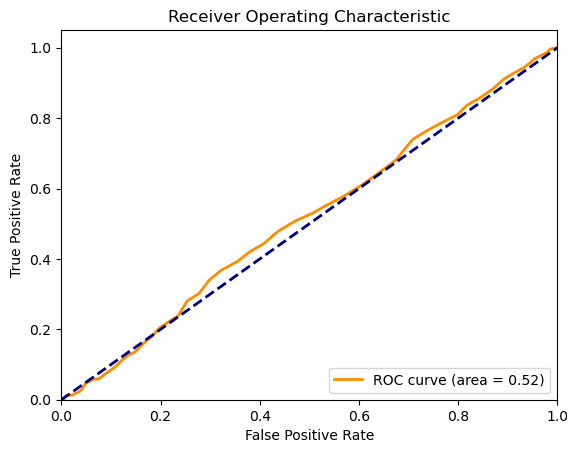

In [371]:
# Get the predicted probabilities for the positive class (1)
y_prob = pipeline.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the Area Under the ROC Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

## Random Forest, Logistic Regression, SVM, Gradient Boosting Evaluation, AdaBoost with no GridSearchCV

While my performance is not good, it appears that the mechanics of the model are working. Thus, I would like to know assess the performance of multiple models

In [375]:
def get_feature_names(column_transformer):
    """Get feature names from a column transformer"""
    output_features = []

    for name, pipe, features in column_transformer.transformers_:
        # The last transformer is ('remainder', 'drop', ...)
        if name == 'remainder':
            continue
        
        if hasattr(pipe, 'get_feature_names_out'):
            feature_names = pipe.get_feature_names_out(features)
        else:
            feature_names = features
            
        output_features.extend(feature_names)
        
    return output_features

Random Forest - Accuracy: 0.75, AUC: 0.51
Confusion Matrix for Random Forest:
[[1775   81]
 [ 530   22]]


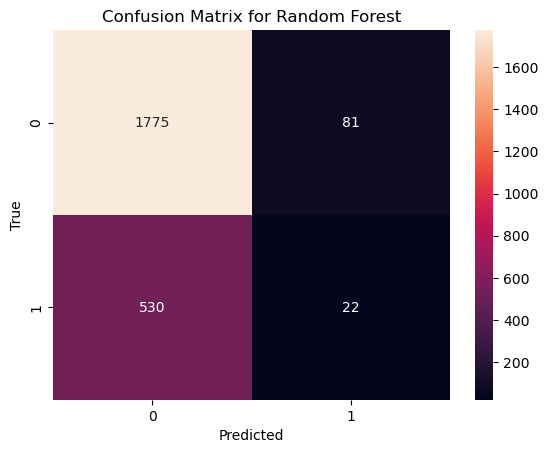


Top Features for Random Forest:
                   Feature  Importance
10               admit_LOS    0.337191
0        total_medications    0.239178
1               anchor_age    0.189263
11  prior_length_of_stay_x    0.087201
2   num_prior_admissions_x    0.036532
4              systolic_bp    0.020515
3             diastolic_bp    0.020304
5                      bmi    0.020081
7   marital_status_MARRIED    0.015172
8    marital_status_SINGLE    0.013506
Logistic Regression - Accuracy: 0.77, AUC: 0.47
Confusion Matrix for Logistic Regression:
[[1856    0]
 [ 551    1]]


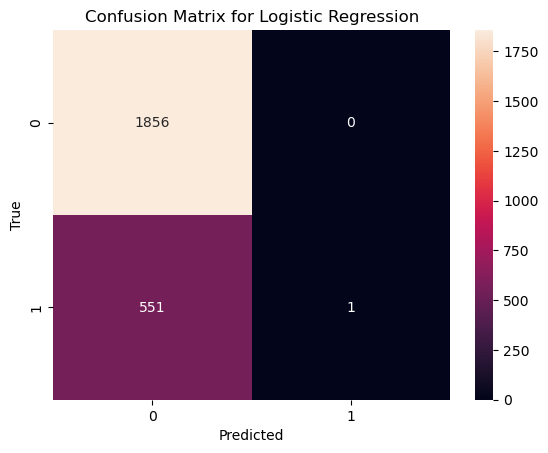

Support Vector Machine - Accuracy: 0.77, AUC: 0.48
Confusion Matrix for Support Vector Machine:
[[1856    0]
 [ 552    0]]


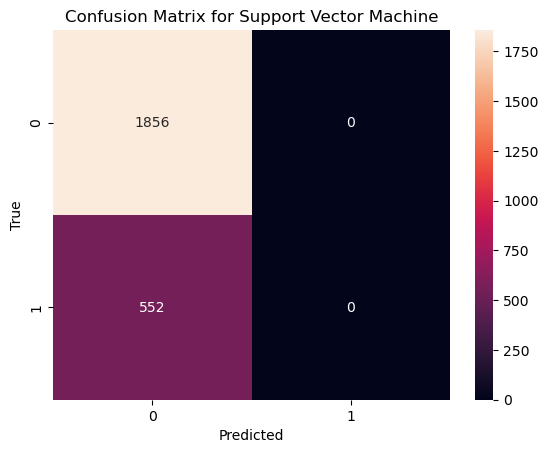

Gradient Boosting - Accuracy: 0.77, AUC: 0.53
Confusion Matrix for Gradient Boosting:
[[1849    7]
 [ 550    2]]


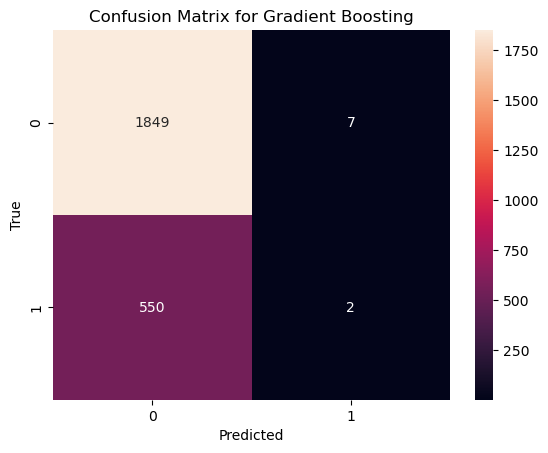


Top Features for Gradient Boosting:
                   Feature  Importance
10               admit_LOS    0.344027
0        total_medications    0.229095
11  prior_length_of_stay_x    0.153675
1               anchor_age    0.115603
2   num_prior_admissions_x    0.065371
3             diastolic_bp    0.032278
4              systolic_bp    0.025715
5                      bmi    0.019116
7   marital_status_MARRIED    0.007905
9   marital_status_WIDOWED    0.004350
AdaBoostClassifier - Accuracy: 0.77, AUC: 0.52
Confusion Matrix for AdaBoostClassifier:
[[1848    8]
 [ 549    3]]


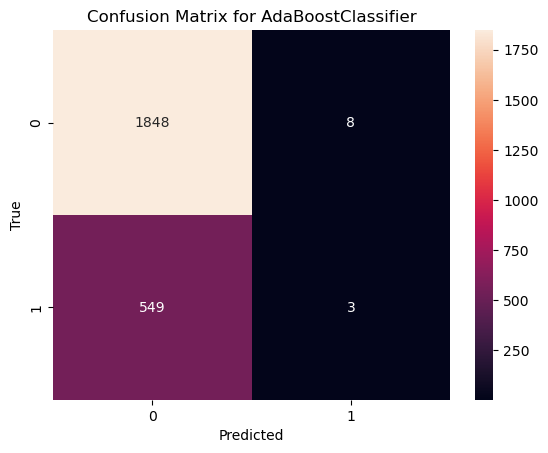


Top Features for AdaBoostClassifier:
                    Feature  Importance
10                admit_LOS        0.46
0         total_medications        0.16
1                anchor_age        0.16
11   prior_length_of_stay_x        0.10
2    num_prior_admissions_x        0.06
3              diastolic_bp        0.02
4               systolic_bp        0.02
5                       bmi        0.02
6   marital_status_DIVORCED        0.00
7    marital_status_MARRIED        0.00


In [396]:
from sklearn.metrics import confusion_matrix
# List of classifiers to evaluate
classifiers = [
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('Support Vector Machine', SVC(probability=True, random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
    ('AdaBoostClassifier', AdaBoostClassifier(random_state=42))
]

# Loop through the classifiers
for name, classifier in classifiers:
    # Create the pipeline with the current classifier
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    
    # Fit the model
    model_pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = model_pipeline.predict(X_test)
    y_prob = model_pipeline.predict_proba(X_test)[:, 1]

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f'{name} - Accuracy: {accuracy:.2f}, AUC: {roc_auc:.2f}')
    
        # Calculate and print the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f'Confusion Matrix for {name}:')
    print(cm)

    # Optionally, visualize the confusion matrix
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
     # Feature importance for models that support it
    if hasattr(classifier, 'feature_importances_'):
        # Get feature names from the preprocessor
        feature_names = get_feature_names(preprocessor)
        
        # Get feature importances
        importances = classifier.feature_importances_
        
        # Create a DataFrame of feature importances
        feature_importances_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)

        # Display the top 10 features
        print(f'\nTop Features for {name}:')
        print(feature_importances_df.head(10))

### Add GridSerachCV to see if performance improves

In [383]:
param_grids = {
    'Random Forest': {'classifier__n_estimators': [100, 200], 'classifier__max_depth': [10, 20]},
    'Logistic Regression': {'classifier__C': [0.1, 1, 10]},
    'Support Vector Machine': {'classifier__C': [0.1, 1, 10]},
    'Gradient Boosting': {'classifier__n_estimators': [100, 200], 'classifier__learning_rate': [0.01, 0.1]},
    'AdaBoostClassifier': {'classifier__n_estimators': [50, 100], 'classifier__learning_rate': [0.01, 0.1]}
}

# List of classifiers to evaluate
classifiers = [
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('Support Vector Machine', SVC(probability=True, random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
    ('AdaBoostClassifier', AdaBoostClassifier(random_state=42))
]

# Loop through the classifiers
for name, classifier in classifiers:
    # Create the pipeline with the current classifier
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    
    # Set up GridSearchCV
    grid_search = GridSearchCV(model_pipeline, param_grids[name], cv=5, scoring='roc_auc', n_jobs=-1)
    
    # Fit the model
    grid_search.fit(X_train, y_train)

    # Best model
    best_model = grid_search.best_estimator_

    # Make predictions
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f'{name} - Accuracy: {accuracy:.2f}, AUC: {roc_auc:.2f}')
    
     # Feature importance for models that support it
    if hasattr(classifier, 'feature_importances_'):
        # Get feature names from the preprocessor
        feature_names = get_feature_names(preprocessor)
        
        # Get feature importances
        importances = classifier.feature_importances_
        
        # Create a DataFrame of feature importances
        feature_importances_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)

        # Display the top 10 features
        print(f'\nTop Features for {name}:')
        print(feature_importances_df.head(10))

C:\Users\blake\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(


Random Forest - Accuracy: 0.77, AUC: 0.55


C:\Users\blake\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(


Logistic Regression - Accuracy: 0.77, AUC: 0.47


C:\Users\blake\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(


Support Vector Machine - Accuracy: 0.77, AUC: 0.50


C:\Users\blake\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(


Gradient Boosting - Accuracy: 0.77, AUC: 0.55


C:\Users\blake\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(


AdaBoostClassifier - Accuracy: 0.77, AUC: 0.53


### My Model Sucks!!

Ah, this is frustrating. The performance of my models is not good. From my initial attempts, I have: 
- Added add'l features to the list, including BMI and Blood Pressure readings at the time of the first admit
- Attempted Add'l Feature Engineering via PolynomialFeatures
- Tried to optimize my parameters with GridSearchCV
- Experiment with 4 different types of models

### Let's add GridSearchCV into the mix

In [252]:
!pip install xgboost

     --------------------------------------- 99.8/99.8 MB 19.8 MB/s eta 0:00:00


In [253]:
from xgboost import XGBClassifier

# Update the pipeline to use XGBClassifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42))
])

# Define a new parameter grid for XGBClassifier
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 7]
}

# Set up GridSearchCV with the new pipeline and parameter grid
xgb_grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='roc_auc').fit(X_train, y_train)

# Evaluate the new model
auc_score = xgb_grid.score(X_test, y_test)
print(f'New AUC with XGBClassifier: {auc_score}')

C:\Users\blake\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\blake\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 373, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\blake\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\blake\anaconda3\lib\site-packages\sklearn\utils\_available_if.py", line 32, in __get__
    if not self.check(obj):
  File "C:\Users\blake\anaconda3\lib\site-packages\sklearn\pipeline.py", line 46, in check
    getattr(self._final_estimator, attr)
AttributeError: 'XGBClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last)

C:\Users\blake\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\blake\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 373, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\blake\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\blake\anaconda3\lib\site-packages\sklearn\utils\_available_if.py", line 32, in __get__
    if not self.check(obj):
  File "C:\Users\blake\anaconda3\lib\site-packages\sklearn\pipeline.py", line 46, in check
    getattr(self._final_estimator, attr)
AttributeError: 'XGBClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last)

C:\Users\blake\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\blake\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 373, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Users\blake\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\blake\anaconda3\lib\site-packages\sklearn\utils\_available_if.py", line 32, in __get__
    if not self.check(obj):
  File "C:\Users\blake\anaconda3\lib\site-packages\sklearn\pipeline.py", line 46, in check
    getattr(self._final_estimator, attr)
AttributeError: 'XGBClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last)

New AUC with XGBClassifier: 0.5396012931034483
